<a href="https://colab.research.google.com/github/chillburg/thesis/blob/master/W%26D_model%2C%20SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import tensorflow as tf
import os

def restart_runtime():
  os.kill(os.getpid(), 9)
print(tf.__version__)
import pip
if tf.__version__ != "1.15.0":
    print('NEED TO RE-INSTALL TF 1.15')
    !pip install tensorflow==1.15
    restart_runtime()
if tf.__version__ != "1.15.0":
    abcd

1.15.0


In [0]:
##############################
### Control Panel

sample_size =       100000  ## Size of the sample (options: integer or 'all')
use_100k_sample =   1       ## use a fixed 100k sample, but pre-process it
use_prepared_data = 1       ## to use saved train/val/test data before modelling (1) or calculate (0)

input_variables =   "16"   ## "all" for all available, anything else for 16 selected
scale  =            1   ## to standardize all variables (True), also for prepared_data and models
interactions =      0   ## to use interactions (True)

resampling =        'iht'   ## to do the resampling (options: 'iht, 'smote', False)
fit_model =         1   ## to fit a new model (True) or load from 'model_weights' (False)
stop_before_shap =  0
add_random =        0   ## add 5 random columns

model_type =        'dw'  # model type ("deep"/"wide"/ any other for D&W)
patience =          30
epochs =            2

##############################

In [0]:
comment = "1 ds" # always has to start with 1-3 sheet number

In [0]:
if use_100k_sample:
    data_path_train = '/content/drive/My Drive/AAA THESIS/Data/model_data_102_100k.csv'
else:
    # full 736k
    data_path_train = '/content/drive/My Drive/AAA THESIS/Data/loan_data_cleaned_FULL_almost_matured_grace_as_ok_TRAIN(589k).csv'
data_path_test = '/content/drive/My Drive/AAA THESIS/Data/loan_data_cleaned_FULL_almost_matured_grace_as_ok_TEST(147k).csv'

#100k with all vars
# data_path = '/content/drive/My Drive/AAA THESIS/Data/model_data_102_100k.csv'

model_weights = '/content/drive/My Drive/AAA THESIS/Models/{}_weights.hdf5'.format(comment[0])
model_history = '/content/drive/My Drive/AAA THESIS/Models/{}_hist.csv'.format(comment[0])

model_weights_norm = '/content/drive/My Drive/AAA THESIS/Models/{}_weights_norm.hdf5'.format(comment[0])
model_history_norm = '/content/drive/My Drive/AAA THESIS/Models/{}_hist_norm.csv'.format(comment[0])

temp_weight_path = "/content/drive/My Drive/AAA THESIS/Models/{}_weights_temp.hdf5".format(comment[0])

# loan_data = pd.read_csv("/content/drive/My Drive/AAA THESIS/Data/loan_data_cleaned 500k.csv", encoding='latin-1').iloc[:, 1:]
# loan_data = pd.read_csv("/content/drive/My Drive/AAA THESIS/Data/loan_data_cleaned FULL matured (670k) 2.csv", encoding='latin-1')#.iloc[:100000, :]
# loan_data = pd.read_csv("/content/drive/My Drive/AAA THESIS/Data/loan_data_cleaned ALL matured with outliers.csv", encoding='latin-1').iloc[:100000, :]

### **Data transformation before modelling**

1.   loads the training and testing set
2.   resamples the training set (IHT or SMOTE)
3.   scales, dummifies and creates interactions
5.   cuts a validation set with a stratified split 
6.   if requested, loads a prepared set
7.   breaks into into wide and deep samples
8.   if requested, adds random noise variables
9.   trains a logistic regresssion as a baseline
7.   trains the original model of Bastani
8.   if requested, does a CV gridsearch of best parameters
9.   trains the modified model
10.  calculates SHAP values
11.  creates SHAP graphs

* try regularizers.l2 https://medium.com/analytics-vidhya/machine-learning-for-unbalanced-datasets-using-neural-networks-b0fc28ef6261
* try decay_rate = learning_rate / epochs

In [0]:
import pandas as pd
# data_path = "/content/drive/My Drive/AAA THESIS/Data/loan_data_cleaned ALL matured with outliers.csv"
loan_data_train = pd.read_csv(data_path_train, nrows = 1).drop(columns = ['Unnamed: 0', 'loan_status', 'loan_condition', 'fico_buckets', 'matured', 'addr_state'])

if input_variables == 'all':
    # select variables to be used as inputs
    cat_vars = list(loan_data_train.select_dtypes(include=['object']).columns)
    print('categorical vars:', cat_vars, "\n")

    num_vars = list(loan_data_train.select_dtypes(include =['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns)
    print('numeric vars:', num_vars, "\n")

    deep_vars = num_vars + cat_vars
    wide_vars = cat_vars
else:
        
    deep_numeric = ['annual_inc', 'cred_hist', 'delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'revol_util', 
                    'loan_to_inc', 'inst_to_inc', 'dti', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'mths_since_last_major_derog',
                 'acc_now_delinq', 'tot_coll_amt', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 
                 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'percent_bc_gt_75', 'tot_hi_cred_lim', 'total_bc_limit']
    deep_categoric = ['sub_grade', 'purpose', 'fico_buckets_bast', 'verification_status', 'initial_list_status', 'term']
    deep_vars = deep_numeric + deep_categoric

    deep_vars = ['annual_inc', 'cred_hist', 'delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'revol_util', 
                  'open_acc', 'mths_since_last_delinq', 'loan_to_inc', 'inst_to_inc', 'dti','sub_grade', 'purpose', 'fico_buckets_bast']
    wide_vars = ['grade', 'sub_grade', 'purpose', 'fico_buckets_bast', 'home_ownership', 'emp_length_cat']
print("Wide:", wide_vars, "\n")
print("Deep:", deep_vars)

Wide: ['grade', 'sub_grade', 'purpose', 'fico_buckets_bast', 'home_ownership', 'emp_length_cat'] 

Deep: ['annual_inc', 'cred_hist', 'delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'revol_util', 'open_acc', 'mths_since_last_delinq', 'loan_to_inc', 'inst_to_inc', 'dti', 'sub_grade', 'purpose', 'fico_buckets_bast']


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import time
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

import tensorflow as tf
import keras
from keras.optimizers import Adam
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Reshape, Concatenate, Dropout, BatchNormalization, Lambda
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.utils import plot_model
import keras.backend as K
from keras.backend import slice
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from IPython.core.interactiveshell import InteractiveShell
from IPython.display import clear_output
from imblearn.under_sampling import InstanceHardnessThreshold
from imblearn.over_sampling import SMOTE, SMOTENC
from patsy import dmatrices
from scipy.interpolate import interp1d

import warnings
warnings.simplefilter(action='ignore', category = FutureWarning)
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:,.2f}'.format

def count_time():
    print((time.time() - start)/60, 'minutes since start')

# send a notification to email
import smtplib
def send_email(user = 'perlaspazzatura1@gmail.com', pwd = 'upzhmynvyqcoqwzh',
               recipient = 'mister.borodach@gmail.com',
               subject = 'COLAB training done', 
               body = 'COLAB'):

    FROM = user
    TO = recipient if isinstance(recipient, list) else [recipient]
    SUBJECT = subject
    TEXT = body

    # Prepare actual message
    message = """From: %s\nTo: %s\nSubject: %s\n\n%s
    """ % (FROM, ", ".join(TO), SUBJECT, TEXT)
    try:
        server = smtplib.SMTP("smtp.gmail.com", 587)
        server.ehlo()
        server.starttls()
        server.login(user, pwd)
        server.sendmail(FROM, TO, message)
        server.close()
        print ('successfully sent the mail')
    except:
        print ("failed to send mail")


from google.colab import output as output_sound
def beep(tune = 'def', email = False, 
         subject = 'COLAB training done',
         body = 'COLAB'):
    if tune == 'beep':
        output_sound.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')
    else:
        output_sound.eval_js('new Audio("https://static.sfdict.com/audio/C07/C0702600.mp3").play()')
    if email:
        send_email(subject = subject, 
                   body = body)

start = time.time()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
# read data
def pd_read(filename, rows = 'all'):
    if rows == 'all':
        df = pd.read_csv(filename, encoding='latin-1').drop(columns = 'Unnamed: 0')
    else:
        n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
        skip = sorted(random.sample(range(1,n+1), n-rows)) #the 0-indexed header will not be included in the skip list
        df = pd.read_csv(filename, skiprows=skip, encoding='latin-1', low_memory=False).drop(columns = 'Unnamed: 0')
    return df

def load_data(data_path_train, data_path_test, sample_size, deep_vars, wide_vars):

    if use_prepared_data == False:
        loan_data_train = pd_read(data_path_train, sample_size)
        loan_data_test = pd_read(data_path_test, min(sample_size, round(sample_size/5)))

        # binarize y
        loan_data_train['loan_condition'] = loan_data_train.loc[:, 'loan_condition'].replace(['good', 'bad'], [0, 1])
        loan_data_test['loan_condition'] = loan_data_test.loc[:, 'loan_condition'].replace(['good', 'bad'], [0, 1])

        # select only necessary variables
        loan_data_train = loan_data_train[list(set(deep_vars +  wide_vars)) + ['loan_condition']]
        loan_data_test = loan_data_test[list(set(deep_vars +  wide_vars)) + ['loan_condition']]
        X_train = loan_data_train[list(set(deep_vars +  wide_vars))]
        y_train = loan_data_train['loan_condition']

        X_test = loan_data_test[list(set(deep_vars +  wide_vars))]
        y_test = loan_data_test['loan_condition']

        print(X_train.shape, y_train.shape)
        print(X_test.shape, y_test.shape)
    return X_train, y_train, X_test, y_test

if use_prepared_data == False:
    X_train, y_train, X_test, y_test = load_data(data_path_train=data_path_train, data_path_test=data_path_test, 
                                             sample_size=sample_size, deep_vars=deep_vars, wide_vars=wide_vars)

In [0]:
%%time

# undersampling the training set with IHT
def iht_und(X, y):
    numeric = X[deep_vars].head(1).select_dtypes(include=['float64', 'int64','float32', 'int32', 'uint8']).columns#[1:]
    iht = InstanceHardnessThreshold(estimator=RandomForestClassifier(), return_indices=True, random_state = 1)
    none, none, idx_r = iht.fit_sample(X[numeric], y)
    X_r = X.iloc[list(idx_r)].reset_index(drop = True)
    y_r = y.iloc[list(idx_r)].reset_index(drop = True)

    count = 1
    print('On loop {} the share of non-defaults is:'.format(count), round((pd.DataFrame(y_r).iloc[:, 0].value_counts()/pd.DataFrame(y_r).shape[0])[0], 2))
    max_loops_allowed = 5
    while (pd.DataFrame(y_r).iloc[:, 0].value_counts()/pd.DataFrame(y_r).shape[0])[0] > 0.55 and count <= max_loops_allowed:
        count += 1
        iht = InstanceHardnessThreshold(estimator=RandomForestClassifier(), return_indices=True)
        none, none, idx_r = iht.fit_sample(X_r[numeric], y_r)
        X_r = pd.DataFrame(X_r).iloc[list(idx_r)].reset_index(drop = True)
        y_r = y_r.iloc[list(idx_r)].reset_index(drop = True)
        print('On loop {} the share of non-defaults is:'.format(count), round((pd.DataFrame(y_r).iloc[:, 0].value_counts()/pd.DataFrame(y_r).shape[0])[0], 2))
    
    print('\nX.shape, X_r.shape: ', X.shape, X_r.shape)
    print('y.shape, y_r.shape: ', y.shape, y_r.shape)
    print('idx_r shape: ', idx_r.shape)
    print('\ny values:\n', y.value_counts())
    print('\ny_r values:\n', y_r.value_counts())

    return(X_r, y_r)

### oversampling the train set with SMOTE

def smote_ovr(X, y):
    sm = SMOTENC(random_state = 1, categorical_features = [11, 12, 13]) #['sub_grade', 'purpose', 'fico_buckets_bast'])#, ratio = 1.0)
    X_r, y_r = sm.fit_sample(X, y)

    X_r = pd.DataFrame(X_r, columns = [X.columns])
    y_r = pd.DataFrame(y_r)
    # X_r.iloc[:, [0, 1, 2, 3, 4, 5, 6 ,7, 8, 9, 10]] = X_r.iloc[:, [0, 1, 2, 3, 4, 5, 6 ,7, 8, 9, 10]].astype('float32')

    print('X.shape, X_r.shape: ', X.shape, X_r.shape)
    print('y.shape, y_r.shape: ', y.shape, y_r.shape)

    print('\ny values:\n', y.value_counts())
    print('\ny_r values:\n', pd.DataFrame(y_r)[0].value_counts())
    return X_r, y_r

def resampling_fun(X_train, y_train, resampling):

    if resampling == 'iht':
        print('Resampling with IHT:')
        X_train_r, y_train_r = iht_und(X_train, y_train)

    elif resampling == 'smote':
        print('Resampling with SMOTE:')
        %time X_train_r, y_train_r = smote_ovr(X_train, y_train)

    else:
        print('No resampling')
        X_train_r, y_train_r = X_train, y_train

    print(X_train.shape, y_train.shape)
    print(X_train_r.shape, y_train_r.shape)

    return X_train_r, y_train_r

if use_prepared_data == False:
    X_train, y_train = resampling_fun(X_train=X_train, y_train=y_train, resampling=resampling)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.63 µs


In [0]:
### scaling the data

def scaling(scale, X_test, X_train_r, deep_vars):
    if scale:
        print('StandScale')
        deep_numeric = []
        for var in X_train_r.head(1).select_dtypes(include=['float64', 'int64','float32', 'int32', 'uint8']).columns:
            if var in deep_vars:
                deep_numeric.append(var)
        print('The deep variables to scale:', deep_numeric)

        sc = StandardScaler()
        X_train_sc = X_train_r.copy()
        X_train_sc[deep_numeric] = sc.fit_transform(X_train_r[deep_numeric])
        X_test_sc = X_test.copy()
        X_test_sc[deep_numeric] = sc.transform(X_test[deep_numeric])

        print(X_train_sc.shape, X_test_sc.shape)
        
        return X_train_sc, X_test_sc


    else:
        print('Not StandScale')
        X_train_sc = X_train_r
        # at least some minor but still interpretable scaling to decrease weight of high magnitude values
        X_train_sc.annual_inc = X_train_sc.annual_inc/1000  # to thousands
        X_train_sc.cred_hist = X_train_sc.cred_hist/30      # to months
        # also, increase weight of percentage varaibles
        X_train_sc.loan_to_inc = X_train_sc.loan_to_inc*100
        X_train_sc.inst_to_inc = X_train_sc.inst_to_inc*100
        
        X_test_sc = X_test
        X_test_sc.annual_inc = X_test_sc.annual_inc/1000  # to thousands
        X_test_sc.cred_hist = X_test_sc.cred_hist/30      # to months
        X_test_sc.loan_to_inc = X_test_sc.loan_to_inc*100
        X_test_sc.inst_to_inc = X_test_sc.inst_to_inc*100

        return X_train_sc, X_test_sc

if use_prepared_data == False:
    X_train_sc, X_test_sc = scaling(scale = scale, X_test = X_test, X_train_r = X_train, deep_vars = deep_vars)

In [0]:
# dummying wide and creating interaction terms for FICO_purpose and subgrade_FICO

def interactions_dumm(X_train_sc, y_train_r, X_test_sc, y_test, interactions):

    X_sc_dum = pd.get_dummies(pd.concat([X_train_sc[wide_vars], X_test_sc[wide_vars]]), drop_first = True)
    X_train_sc_dum = X_sc_dum.iloc[:X_train_sc.shape[0], :]
    X_test_sc_dum = X_sc_dum.iloc[X_train_sc.shape[0]: ,:]

    if interactions:
        print('Creating interactions')
        # create interactions from both sets
        data_concated = pd.concat([pd.concat([X_train_sc, y_train_r], axis = 1),
                                   pd.concat([X_test_sc,  y_test], axis = 1)])
        none, fico_x_purpose = dmatrices('loan_condition ~ C(fico_buckets_bast)*C(purpose)', data_concated, return_type="dataframe")
        none, subgrade_x_fico = dmatrices('loan_condition ~ C(sub_grade)*C(fico_buckets_bast)', data_concated, return_type="dataframe")
        print('Interaction shapes:', fico_x_purpose.shape, subgrade_x_fico.shape)

        # leaving only interaction terms
        X_inter = pd.concat([fico_x_purpose, subgrade_x_fico], axis = 1).filter(regex = '\]:C')

        # splitting interactions into train and test sets
        X_train_inter = X_inter.iloc[:X_train_sc.shape[0], :]
        X_test_inter = X_inter.iloc[X_train_sc.shape[0]: ,:]
        # print("Interaction terms together:", X_inter.shape, "\nEach:", X_train_inter.shape, X_test_inter.shape)
        ### concatenating scaled deep variables with dummy encoded wide variables and interaction terms

        # uniting scaled deep variables, dummied wide variables and interaction terms
        X_train_sc_dum_inter = pd.concat([X_train_sc[deep_vars], X_train_sc_dum, X_train_inter], axis = 1)
        X_test_sc_dum_inter = pd.concat([X_test_sc[deep_vars], X_test_sc_dum, X_test_inter], axis = 1)

        # checking for duplicate columns
        # print('Shape with duplicate columns: {}, {}'.format(X_train_sc_dum_inter.shape, X_test_sc_dum_inter.shape))
        X_train_sc_dum_inter = X_train_sc_dum_inter.iloc[:,~X_train_sc_dum_inter.columns.duplicated(keep = False)]  # removing duplicated columns of fico_buckets_bast due to two interactions with it
        X_test_sc_dum_inter = X_test_sc_dum_inter.iloc[:,~X_test_sc_dum_inter.columns.duplicated(keep = False)]
        # print('Shape without duplicate columns: {}, {}'.format(X_train_sc_dum_inter.shape, X_test_sc_dum_inter.shape))
        
        print('/nShapes of datasets with interaction terms (train/test):', X_train_sc_dum_inter.shape, X_test_sc_dum_inter.shape)
        return X_train_sc_dum_inter, X_test_sc_dum_inter

    else:
        print('Not creating interactions')
        # uniting deep variables and dummied wide variables
        X_train_sc_dum_inter = pd.concat([X_train_sc[deep_vars], X_train_sc_dum], axis = 1)
        X_test_sc_dum_inter  = pd.concat([X_test_sc[deep_vars], X_test_sc_dum], axis = 1)
        # checking for duplicate columns
        # print('Shape with duplicate columns: {}, {}'.format(X_train_sc_dum_inter.shape, X_test_sc_dum_inter.shape))        
        X_train_sc_dum_inter = X_train_sc_dum_inter.iloc[:,~X_train_sc_dum_inter.columns.duplicated(keep = False)]  # removing duplicated columns of fico_buckets_bast due to two interactions with it
        X_test_sc_dum_inter = X_test_sc_dum_inter.iloc[:,~X_test_sc_dum_inter.columns.duplicated(keep = False)]
        # print('Shape without duplicate columns: {}, {}'.format(X_train_sc_dum_inter.shape, X_test_sc_dum_inter.shape))
        
        print('/nShapes of datasets with interaction terms (train/test):', X_train_sc_dum_inter.shape, X_test_sc_dum_inter.shape)
        return X_train_sc_dum_inter, X_test_sc_dum_inter

if use_prepared_data == False:
    X_train, X_test = interactions_dumm(X_train_sc = X_train_sc, X_test_sc = X_test_sc, y_train_r = y_train, y_test = y_test, interactions = interactions)

In [0]:
# creating a validation set
if use_prepared_data == False:

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 1, stratify = y_train)

    X_train = X_train.reset_index(drop=True)
    X_val = X_val.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_val = y_val.reset_index(drop=True)

    print("Training shapes:", X_train.shape, y_train.shape)
    print("Validation shapes:", X_val.shape, y_val.shape)
    X_train.head(10)

In [0]:
def loading_prepared_data(scale, sample_size, interactions):

    if scale:
        print("Scaling the data")
        scaling = 'norm'
    else:
        print("Not scaling the data")
        scaling = 'not_norm'

    if sample_size == 'all':
        print("Using all data sample")
        sample = 'all_'

    else:
        print("Using a smaller sample")
        sample = ""

    print('Reading from: /content/drive/My Drive/AAA THESIS/Data/X_train_{}{}.csv'.format(sample, scaling))

    X_train = pd.read_csv('/content/drive/My Drive/AAA THESIS/Data/X_train_{}{}.csv'.format(sample, scaling)).drop(columns = 'Unnamed: 0')
    X_val = pd.read_csv('/content/drive/My Drive/AAA THESIS/Data/X_val_{}{}.csv'.format(sample, scaling)).drop(columns = 'Unnamed: 0')
    X_test = pd.read_csv('/content/drive/My Drive/AAA THESIS/Data/X_test_{}{}.csv'.format(sample, scaling)).drop(columns = 'Unnamed: 0')
    
    y_train = pd.read_csv('/content/drive/My Drive/AAA THESIS/Data/y_train_{}{}.csv'.format(sample, scaling)).drop(columns = 'Unnamed: 0')
    y_val = pd.read_csv('/content/drive/My Drive/AAA THESIS/Data/y_val_{}{}.csv'.format(sample, scaling)).drop(columns = 'Unnamed: 0')
    y_test = pd.read_csv('/content/drive/My Drive/AAA THESIS/Data/y_test_{}{}.csv'.format(sample, scaling)).drop(columns = 'Unnamed: 0')

    print(X_train.shape, X_val.shape, X_test.shape)
    print(y_train.shape, " ", y_val.shape, " ", y_test.shape)
    X_train.head()

    # dummying the wide variables
    X_wide = pd.get_dummies(pd.concat([X_train[wide_vars], X_val[wide_vars], X_test[wide_vars]]), drop_first = True)
    X_train_w = X_wide.iloc[:X_train.shape[0], :]
    X_val_w   = X_wide.iloc[:(X_train.shape[0]+X_val.shape[0]), :].iloc[X_train.shape[0]:, :]
    X_test_w  = X_wide.iloc[(X_train.shape[0]+X_val.shape[0]):, :]

    # uniting everything
    if interactions:
        X_train = pd.concat([X_train[deep_vars], X_train_w, X_train.filter(regex = '\]:C')], axis = 1)
        X_val   = pd.concat([X_val[deep_vars],   X_val_w,   X_val.filter(regex = '\]:C')], axis = 1)
        X_test  = pd.concat([X_test[deep_vars],  X_test_w,  X_test.filter(regex = '\]:C')], axis = 1)
    else:
        X_train = pd.concat([X_train[deep_vars], X_train_w], axis = 1)
        X_val   = pd.concat([X_val[deep_vars],   X_val_w], axis = 1)
        X_test  = pd.concat([X_test[deep_vars],  X_test_w], axis = 1)


    return X_train, X_val, X_test, y_train, y_val, y_test


if use_prepared_data:
    X_train, X_val, X_test, y_train, y_val, y_test = loading_prepared_data(scale = scale, sample_size = sample_size, interactions = interactions)
print("The options are: scale={}, sample_size={:,.1f}, interactions={}, use_prepared_data={}, input_variables={}".format(scale, sample_size, interactions, use_prepared_data, input_variables))

Scaling the data
Using a smaller sample
Reading from: /content/drive/My Drive/AAA THESIS/Data/X_train_norm.csv
(26942, 2039) (6736, 2040) (20000, 2040)
(26942, 1)   (6736, 1)   (20000, 1)
The options are: scale=1, sample_size=100,000.0, interactions=0, use_prepared_data=1, input_variables=16


In [0]:
# creating wide and deep input samples
X_train_w = X_train.drop(columns = deep_vars)
X_train_d = X_train[deep_vars]

X_val_w = X_val.drop(columns = deep_vars)
X_val_d = X_val[deep_vars]

X_test_w = X_test.drop(columns = deep_vars)
X_test_d = X_test[deep_vars]

print(X_train_w.shape, y_train.shape)
print(X_train_d.shape, y_train.shape)

print(X_val_w.shape, y_val.shape)
print(X_val_d.shape, y_val.shape)

print(X_test_w.shape, y_test.shape)
print(X_test_d.shape, y_test.shape)

(26942, 104) (26942, 1)
(26942, 14) (26942, 1)
(6736, 104) (6736, 1)
(6736, 14) (6736, 1)
(20000, 104) (20000, 1)
(20000, 14) (20000, 1)


In [0]:
# adding random features
def add_rand_features(X_train_d, X_val_d, X_test_d, scale):
    if 'rand_norm' in X_train_d.columns:
        return X_train_d, X_val_d, X_test_d

    rows = X_train_d.shape[0]+X_val_d.shape[0] + X_test_d.shape[0]
    random.seed(1)

    X_rand = pd.DataFrame(np.random.randn(rows, 1), columns = ['rand_norm'])
    X_rand['rand_exp'] = np.random.exponential(1, size=rows)
    X_rand['rand_exp_class'] = np.round(np.random.exponential(1, size=rows),0)
    X_rand['rand_binomial'] = np.random.random((rows,1))*10
    X_rand['rand_mix'] = X_rand.rand_norm*X_rand.rand_exp + X_rand.rand_binomial*X_rand.rand_binomial/10
    X_rand.plot.hist(bins=100)

    X_train_rand = X_rand.iloc[:X_train_d.shape[0], :].reset_index(drop=1)
    X_val_rand = X_rand.iloc[:(X_train_d.shape[0]+X_val_d.shape[0]), :].iloc[X_train_d.shape[0]:, :].reset_index(drop=1)
    X_test_rand = X_rand.iloc[(X_train_d.shape[0]+X_val_d.shape[0]):, :].reset_index(drop=1)
    # print(X_train_rand.shape, X_val_rand.shape, X_test_rand.shape)

    if scale:
        sc_rand = StandardScaler().fit(pd.concat([X_train_rand, X_val_rand]))
        X_train_rand = pd.DataFrame(sc_rand.transform(X_train_rand), columns = X_rand.columns)
        X_val_rand   = pd.DataFrame(sc_rand.transform(X_val_rand), columns = X_rand.columns)
        X_test_rand  = pd.DataFrame(sc_rand.transform(X_test_rand), columns = X_rand.columns)

    X_train_d = pd.concat([X_train_d, X_train_rand], axis = 1)
    X_val_d   = pd.concat([X_val_d, X_val_rand], axis = 1) 
    X_test_d  = pd.concat([X_test_d, X_test_rand], axis = 1)

    # re-arrange so that categoric vals would be in the end (for the model)
    numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    X_train_d = pd.concat([X_train_d.select_dtypes(include=numerics), X_train_d.select_dtypes(include=['object'])], axis = 1)
    X_val_d = pd.concat([X_val_d.select_dtypes(include=numerics), X_val_d.select_dtypes(include=['object'])], axis = 1)
    X_test_d = pd.concat([X_test_d.select_dtypes(include=numerics), X_test_d.select_dtypes(include=['object'])], axis = 1)

    return X_train_d, X_val_d, X_test_d

if add_random:
    X_train_d, X_val_d, X_test_d = add_rand_features(X_train_d = X_train_d, X_val_d = X_val_d, X_test_d = X_test_d, scale = scale)

# Logistic Regression baseline

In [0]:
def print_score(model, X_train, y_train, X_test, y_test, train=False, border = 0.5):
    print('Decision boundary is {}'.format(border))
    y_pred = pd.DataFrame(model.predict_proba(X_test) < border).replace([True, False], [0, 1]).drop(columns = 0)
    print("Test Result:\n")        
    print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, y_pred)))
    print("Classification Report: \n {}\n".format(classification_report(y_test, y_pred)))
    print("\nPredicted \n  NonDef  Def\n {}".format(confusion_matrix(y_test, y_pred)))
    baseline = y_test.copy().replace(1, 0)
    print('\n#################### The baseline ######################## \naccuracy is: ', accuracy_score(y_test, baseline), '\n', classification_report(y_test, baseline), '\n', confusion_matrix(y_test, baseline))

    ### from https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
    y_pred = model.predict_proba(X_test)[:,1]
    # # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, y_pred)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Model: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred)
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label= "Model's")
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.title("ROC")
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

def print_score_nn(model, X_train, y_train, X_test, y_test, train=True, border = 0.5):
    y_pred = pd.DataFrame(model.predict(X_test, verbose = 0) < border).replace([True, False], [0, 1])
    print("Test Result:\n")        
    print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, y_pred)))
    print("Classification Report: \n {}\n".format(classification_report(y_test, y_pred)))
    print("\nPredicted \n  NonDef  Def\n {}".format(confusion_matrix(y_test, y_pred)))
    print("\nIn percentages \n  NonDef  Def\n {}".format((confusion_matrix(y_test, y_pred)/y_test.shape[0]).round(2)))
    print('\n', model.metrics_names)
    print(model.evaluate(X_test, y_test, batch_size=10, verbose = 0))

    baseline = y_test.copy().replace(1, 0)
    print('\n#################### The baseline ######################## \naccuracy is: ', accuracy_score(y_test, baseline), '\n', classification_report(y_test, baseline), '\n', confusion_matrix(y_test, baseline))
    
    ### from https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
    y_pred = model.predict(X_test, verbose = 0)
    # # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, y_pred)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Model: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred)
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label= "Model's")
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.title("ROC")
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()
    return (lr_auc)

def rename_variables(names, index = False):
    name_new = []
    name_dict = {'dti': 'Debt to Income ratio', 
                'inq_last_6mths':'Inquiries in last 6 months',
                'inst_to_inc': 'Annual installment to annual income ratio',
                'loan_to_inc': 'Loan amount to annual income ratio',
                'revol_util': 'Credit utilization rate',
                'pub_rec': 'Number of derogatory marks in credit report',
                'delinq_2yrs': 'Number of 30+ day delinquencies in past 2 years',
                'mths_since_last_delinq': 'Number of months since borrowers last delinquency',
                'open_acc': 'Number of open accounts in credit report',
                'cred_hist': 'Time from first credit line in credit report',
                'annual_inc' : 'Annual income',
                'purpose_debt_consolidation': 'Purpose of loan: debt consolidation',
                'purpose_moving': 'Purpose of loan: moving',
                'purpose_medical': 'Purpose of loan: medical',
                'purpose_wedding': 'Purpose of loan: wedding',
                'purpose_vacation': 'Purpose of loan: vacation',
                'purpose_educational': 'Purpose of loan: educational',
                'purpose_major_purchase': 'Purpose of loan: major purchase',
                'purpose_car': 'Purpose of loan: car',
                'purpose_credit_card': 'Purpose of loan: credit card',
                'purpose_home_improvement': 'Purpose of loan: home improvement',                            
                'purpose_small_business': 'Purpose of loan: small business',
                'sub_grade': 'Sub grade',
                'purpose' : 'Purpose of the loan',
                'fico_buckets_bast' : 'FICO credit score'}
   
    if index == True:
        for name in names.index:
            name_new.append(name.replace('fico_buckets_bast_', 'FICO credit score ')
            .replace('sub_grade_', 'Lending Club credit subgrade ')
            .replace('grade_', 'Lending Club credit grade ')
            .replace('purpose_', 'Purpose of the loan: ')
            .replace('emp_length_cat_', 'Emloyment length: ')
            .replace('emp_length_', 'Emloyment length: ')
            .replace('home_ownership_', 'Home ownership: ')
            )
        names.index = name_new
        names = names.rename(name_dict)
        
    else:
        for name in names.columns:
            name_new.append(name.replace('fico_buckets_bast_', 'FICO credit score ')
            .replace('sub_grade_', 'Lending Club credit subgrade ')
            .replace('grade_', 'Lending Club credit grade ')
            .replace('purpose_', 'Purpose of the loan: ')
            .replace('emp_length_cat_', 'Employment lenght: ')
            .replace('emp_length_', 'Employment lenght: ')
            .replace('home_ownership_', 'Home ownership: ')
            )
        names.columns = name_new
        names = names.rename(columns = name_dict)
    
    return names

def show_type():
    text = "The model was {model}, param = {pm}, shape = {sh}, epochs = {ep}, patience = {pt}, resampling = {rs}, interactions = {int}, norm = {sc}, sample = {ss:,.0f}".format(model = model_type, ep = epochs, pt = patience, rs = resampling, int = interactions, sc = scale, ss = sample_size, pm = len(wide_vars+deep_vars), sh = X_train_enc.shape)
    return text

In [0]:
### logistic regression as a baseline and some insights into variables   AUC=0.589, 0.596

def log_reg(X_train, X_val, X_test, y_train, y_test):
    model_lg = LogisticRegression(C = 0.0001, random_state=1)

    dummied_all = pd.get_dummies(pd.concat([X_train, X_val, X_test]), drop_first = True)
    X_train_dummied_all = dummied_all.iloc[:X_train.shape[0], :]
    X_test_dummied_all = dummied_all.iloc[(X_train.shape[0]+X_val.shape[0]):, :]

    model_lg.fit(X_train_dummied_all, y_train)
    print(dummied_all.shape)
    print_score(model_lg, X_train_dummied_all, y_train, X_test_dummied_all, y_test, border = 0.5)

    # preparing indices
    indices = dummied_all.columns
    lor_coef = pd.Series(model_lg.coef_[0], index = indices)
    lor_coef = pd.DataFrame({'exp(β)':lor_coef.apply(lambda x:np.exp(x))}).round(3).sort_values('exp(β)', ascending = False)

    lor_coef = rename_variables(lor_coef, index = True)
    lor_coef = lor_coef.reset_index().rename(columns = {'index':'Variable'}).style.set_properties(**{'text-align': 'left'}).background_gradient('coolwarm', axis = 0)

    return model_lg, lor_coef

# model_lg, lor_coef = log_reg(X_train=X_train_d, X_val=X_val_d, X_test=X_test_d, y_train=y_train, y_test=y_test)

(53678, 95)
Decision boundary is 0.5
Test Result:

accuracy score: 0.5821

Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.58      0.70     16901
           1       0.21      0.60      0.31      3099

    accuracy                           0.58     20000
   macro avg       0.55      0.59      0.50     20000
weighted avg       0.78      0.58      0.64     20000



Predicted 
  NonDef  Def
 [[9776 7125]
 [1232 1867]]

#################### The baseline ######################## 
accuracy is:  0.84505 
               precision    recall  f1-score   support

           0       0.85      1.00      0.92     16901
           1       0.00      0.00      0.00      3099

    accuracy                           0.85     20000
   macro avg       0.42      0.50      0.46     20000
weighted avg       0.71      0.85      0.77     20000
 
 [[16901     0]
 [ 3099     0]]
No Skill: ROC AUC=0.500
Model: ROC AUC=0.631


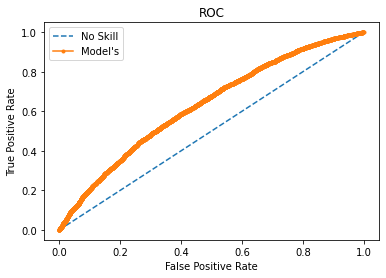

In [0]:
### logistic regression as a baseline and some insights into variables   AUC=0.589, 0.596

def log_reg(X_train, X_val, X_test, y_train, y_test):
    model_lg = LogisticRegression(C = 0.0001, random_state=1)

    dummied_all = pd.get_dummies(pd.concat([X_train, X_val, X_test]), drop_first = True)
    X_train_dummied_all = dummied_all.iloc[:X_train.shape[0], :]
    X_test_dummied_all = dummied_all.iloc[(X_train.shape[0]+X_val.shape[0]):, :]

    model_lg.fit(X_train_dummied_all, y_train)
    print(dummied_all.shape)
    print_score(model_lg, X_train_dummied_all, y_train, X_test_dummied_all, y_test, border = 0.5)

    # preparing indices
    indices = dummied_all.columns
    lor_coef = pd.Series(model_lg.coef_[0], index = indices)
    lor_coef = pd.DataFrame({'exp(β)':lor_coef.apply(lambda x:np.exp(x))}).round(3).sort_values('exp(β)', ascending = False)

    lor_coef = rename_variables(lor_coef, index = True)
    lor_coef = lor_coef.reset_index().rename(columns = {'index':'Variable'}).style.set_properties(**{'text-align': 'left'}).background_gradient('coolwarm', axis = 0)

    return model_lg, lor_coef

model_lg, lor_coef = log_reg(X_train=X_train_d, X_val=X_val_d, X_test=X_test_d, y_train=y_train, y_test=y_test)

(53678, 199)
Decision boundary is 0.5
Test Result:

accuracy score: 0.5723

Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.56      0.69     16901
           1       0.21      0.65      0.32      3099

    accuracy                           0.57     20000
   macro avg       0.56      0.61      0.50     20000
weighted avg       0.79      0.57      0.63     20000



Predicted 
  NonDef  Def
 [[9422 7479]
 [1076 2023]]

#################### The baseline ######################## 
accuracy is:  0.84505 
               precision    recall  f1-score   support

           0       0.85      1.00      0.92     16901
           1       0.00      0.00      0.00      3099

    accuracy                           0.85     20000
   macro avg       0.42      0.50      0.46     20000
weighted avg       0.71      0.85      0.77     20000
 
 [[16901     0]
 [ 3099     0]]
No Skill: ROC AUC=0.500
Model: ROC AUC=0.647


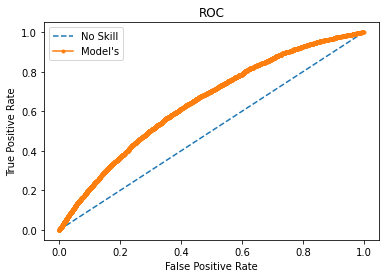

In [0]:
### logistic regression with interactions   # AUC=0.602, 0.606

model_lg_all, lor_coef_all = log_reg(X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_test=y_test)

In [0]:
# extracting coefficients
lor_coef
# lor_coef_all

# Building the W&D with splits

### Preparing functions

In [0]:
# define lambda function to split input
def lambda_fun(x) : 
    x = K.expand_dims(x, 4)
    split1 = tf.split(x, 16, 2)
    x = K.concatenate(split1, 4)
    split2 = tf.split(x, 16, 3)
    x = K.concatenate(split2, 4)
    return x

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

# define a class to visualize training performance
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize = (12, 5))
        
        # clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot_losses = PlotLearning()

def plot_history(history):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))

    ax1.plot(history['loss'])
    ax1.plot(history['val_loss'])
    ax1.legend(['train loss', 'test loss'], loc='upper right')

    ax2.plot(history['acc'])
    ax2.plot(history['val_accuracy'])
    ax2.legend(['train acc', 'test acc'], loc='lower right')

from sklearn.utils.validation import check_is_fitted
from sklearn.utils import column_or_1d

class SafeLabelEncoder(LabelEncoder):
    """An extension of LabelEncoder that will
    not throw an exception for unseen data, but will
    instead return a default value of 99999
    from https://tgsmith61591.github.io/skutil/_modules/skutil/preprocessing/encode.html#SafeLabelEncoder

    Attributes
    ----------
    classes_ : the classes that are encoded
    """
    def transform(self, y):
        """Perform encoding if already fit.
        Parameters
        ----------
        y : array_like, shape=(n_samples,)
            The array to encode
        Returns
        -------
        e : array_like, shape=(n_samples,)
            The encoded array
        """
        check_is_fitted(self, 'classes_')
        y = column_or_1d(y, warn=True)

        classes = np.unique(y)
        # _check_numpy_unicode_bug(classes)

        # Check not too many:
        unseen = _get_unseen()
        if len(classes) >= unseen:
            raise ValueError('Too many factor levels in feature. Max is %i' % unseen)

        e = np.array([
                         np.searchsorted(self.classes_, x) if x in self.classes_ else unseen
                         for x in y
                         ])
        return e

def _get_unseen():
    """Basically just a static method
    instead of a class attribute to avoid
    someone accidentally changing it."""
    return 99999

In [0]:
# encoding deep categorical vars as integers for embedding

# enc = LabelEncoder()
enc = SafeLabelEncoder()

X_train_enc = pd.concat([X_train_d, X_train_w], axis = 1)
X_val_enc = pd.concat([X_val_d, X_val_w], axis = 1)
X_test_enc = pd.concat([X_test_d, X_test_w], axis = 1)

for var in X_train_d.select_dtypes(include=['object']):
    enc.fit(pd.concat([X_train[var], X_val[var] ]))
    X_train_enc[var] = enc.transform(X_train[var])
    X_val_enc[var] =   enc.transform(X_val[var])
    X_test_enc[var] =  enc.transform(X_test[var])

print(X_train_enc.shape)
X_train_enc.head()

(26942, 118)


annual_inc  cred_hist  delinq_2yrs  inq_last_6mths  pub_rec  revol_util  open_acc  mths_since_last_delinq  loan_to_inc  inst_to_inc   dti  sub_grade  purpose  fico_buckets_bast  grade_B  grade_C  grade_D  grade_E  grade_F  grade_G  sub_grade_A2  sub_grade_A3  sub_grade_A4  sub_grade_A5  sub_grade_B1  sub_grade_B2  sub_grade_B3  sub_grade_B4  sub_grade_B5  sub_grade_C1  sub_grade_C2  sub_grade_C3  sub_grade_C4  sub_grade_C5  sub_grade_D1  sub_grade_D2  sub_grade_D3  sub_grade_D4  sub_grade_D5  sub_grade_E1  sub_grade_E2  sub_grade_E3  sub_grade_E4  sub_grade_E5  sub_grade_F1  sub_grade_F2  sub_grade_F3  sub_grade_F4  sub_grade_F5  sub_grade_G1  sub_grade_G2  sub_grade_G3  sub_grade_G4  sub_grade_G5  purpose_credit_card  purpose_debt_consolidation  purpose_educational  purpose_home_improvement  purpose_house  purpose_major_purchase  purpose_medical  purpose_moving  purpose_other  purpose_renewable_energy  purpose_small_business  purpose_vacation  purpose_wedding  \
0       -0.63       2.06        -0.35           -0.65    -0.30        0.73     -0.25                   -0.67         0.98         0.24 -0.99         11        1                 12        0        1        0        0        0        0             0             0             0             0             0             0             0             0             0             0             1             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0                    1                           0                    0                         0              0                       0                0               0              0                         0                       0                 0                0   
1       -0.59       0.16        -0.35           -0.65    -0.30        0.16      0.16                   -0.67        -0.65        -0.58  0.19          9        2                  8        1        0        0        0        0        0             0             0             0             0             0             0             0             0             1             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0                    0                           1                    0                         0              0                       0                0               0              0                         0                       0                 0                0   
2        0.56      -1.15        -0.35           -0.65    -0.30       -0.17     -0.46                   -0.67        -0.54        -0.54 -0.98          4        2                  7        0        0        0        0        0        0             0             0             0             1             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0                    0                           1                    0                         0              0                       0                0               0              0                         0                       0                 0                0   
3       -0.47      -1.10        -0.35            1.52    -0.30       -1.02     

In [0]:
# a function to create a model
print(show_type())

def create_model_api(learn_rate = 0.00005, drop = 0.4, size = 100, layers = 3, embed_type = 'flex'):
    print('Creating model...')
    numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    count_numeric_in_d = X_train_d.select_dtypes(include=numerics).shape[1]
    output_embeddings = []

    inputs = Input(shape=(X_train_enc.shape[1], ), name = "MAIN_INPUT")

    inp_deep_num = Lambda( lambda x: slice(x, (0, 0 ), (-1, count_numeric_in_d)), name = 'SPLIT_DEEP_NUMERIC')(inputs)      # deep continuous variables (11)

    count_of_emb = 0
    #creating an embedding for each categorical var in deep input
    for categorical_var in X_train_d.select_dtypes(include=['object']):
        # to allow setting embedding size
        if embed_type == 'flex':
            embed_size = round(X_train_d[categorical_var].nunique()/2+1)
        else:
            embed_size = embed_type

        x_emb = Lambda( lambda x: slice(x, (0, count_numeric_in_d + count_of_emb), (-1, 1)), name = 'SPLIT_DEEP_EMB_{}'.format(categorical_var))(inputs)

        count_of_emb += 1
        embed = Embedding(input_dim = X_train[categorical_var].nunique()+10, output_dim = embed_size, name = 'EMBEDDING_{}'.format(categorical_var))(x_emb)
        embed = Reshape(target_shape=(embed_size,))(embed)
        output_embeddings.append(embed)

    inp_wide = Lambda( lambda x: slice(x, (0, count_numeric_in_d + count_of_emb), (-1, X_train_enc.shape[1]-(count_numeric_in_d + count_of_emb))), name = "SPLIT_WIDE")(inputs)     # wide one-hot encoded variables (94) + interactions ()   # data.shape[1]-14 or 108

    output_embeddings.append(inp_deep_num)
    concat = keras.layers.concatenate(output_embeddings)

    output = Dense(size, kernel_initializer = "uniform", activation= 'relu')(concat)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)
    output = Dropout(drop)(output)

    if layers >=4:
        output = Dense(size, kernel_initializer = "uniform", activation= 'relu')(concat)
        output = BatchNormalization()(output)
        output = Activation('relu')(output)
        output = Dropout(drop)(output)

    if layers >=5:
        output = Dense(size, kernel_initializer = "uniform", activation= 'relu')(concat)
        output = BatchNormalization()(output)
        output = Activation('relu')(output)
        output = Dropout(drop)(output)
    
    output = Dense(int(size/2), kernel_initializer = "uniform")(output)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)
    output = Dropout(drop)(output)

    output = Dense(10, kernel_initializer = "uniform")(output)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)
    output = Dropout(drop-0.1)(output)

    prediction_d = Dense(1, activation = 'sigmoid')(output)
    prediction_w = Dense(1, activation = 'sigmoid')(inp_wide)

    concat2 = keras.layers.concatenate([output, inp_wide])
    prediction = Dense(1, activation = 'sigmoid')(concat2)


    if model_type == "wide":
        print("Using the Wide model")
        model = Model(inputs = inputs, outputs= prediction_w)    # Wide
    elif model_type == 'deep':
        print("Using the Deep model")
        model = Model(inputs = inputs, outputs= prediction_d)    # Deep
    else:
        print("Using the W&D model")
        model = Model(inputs = inputs, outputs= prediction)      # Wide and Deep
        
    print(show_type())

    opt = Adam(lr = learn_rate)
    lr_metric = get_lr_metric(opt)    

    model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy', lr_metric])
    
    es = EarlyStopping(monitor = 'val_loss', verbose = 1, patience = patience, min_delta = 0.0005)
    check = ModelCheckpoint(temp_weight_path, monitor='val_loss',
                            save_best_only = True, verbose = 1)

    return model, es, check

The model was dw, param = 20, shape = (26942, 118), epochs = 2, patience = 30, resampling = iht, interactions = 0, norm = 1, sample = 100,000


### GridsearchCV model tuning

In [0]:
model_start = time.time()
grid_search = False    # set to True to run

if grid_search:
    model_api = KerasClassifier(build_fn=create_model_api, verbose=1)

    # define the grid search parameters
    learn_rate = [0.0001, 0.00005]
    dropout = [0.3, 0.4, 0.5]
    node_size = [100, 300]
    layers = [3, 5]
    param_grid_api = dict(learn_rate=learn_rate, drop = dropout, size = node_size, layers = layers)

    grid_api = GridSearchCV(estimator=model_api, param_grid=param_grid_api, 
                            # scoring='roc_auc', 
                            n_jobs=-1, 
                            cv= StratifiedShuffleSplit(n_splits=1,test_size=0.3,random_state = 0),
                            verbose = 3)



    print('Fitting...')
    grid_result_api = grid_api.fit(X_train_enc, y_train, validation_data = (X_val_enc, y_val),
                            epochs =  epochs,
                            batch_size = 8,
                            shuffle = True, callbacks = [es])  # [check, es, plot_losses]

    print("Best: %f using %s" % (grid_result_api.best_score_, grid_result_api.best_params_))

    means = grid_result_api.cv_results_['mean_test_score']
    stds = grid_result_api.cv_results_['std_test_score']
    params = grid_result_api.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    runs = pd.DataFrame(zip(means, stds, params))
    runs[0] = pd.DataFrame(zip(means, stds, params)).apply(lambda x: "{:,.4f}".format(x[0]), axis=1)

    beep(tune = 'beep', email = 1, 
        subject = "Best: %f using %s" % (grid_result_api.best_score_, grid_result_api.best_params_),
        body = runs)

print('Model run time: {} min'.format(round((time.time() - model_start)/60, 1)))
print('Time from beginning is : {} min'.format(round((time.time() - start)/60, 1)))

Model run time: 0.0 min
Time from beginning is : 0.4 min


### Running the model

Creating model...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Using the W&D model
The model was dw, param = 20, shape = (26942, 118), epochs = 2, patience = 30, resampling = iht, interactions = 0, norm = 1, sample = 100,000
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 26942 samples, validate on 6736 samples
Epoch 1/1000
26942/26942 [==============================] - 2s 73us/step - loss: 0.3557 - accuracy: 0.8548 - lr: 0.0020 - val_loss: 0.3289 - val_accuracy: 0.8671 - val_lr: 0.0020

Epoch 00001: val_loss improved from inf to 0.32892, saving model to /content/drive/My Drive/AAA THESIS/Models/1_weights_temp.hdf5


<Figure size 432x288 with 0 Axes>

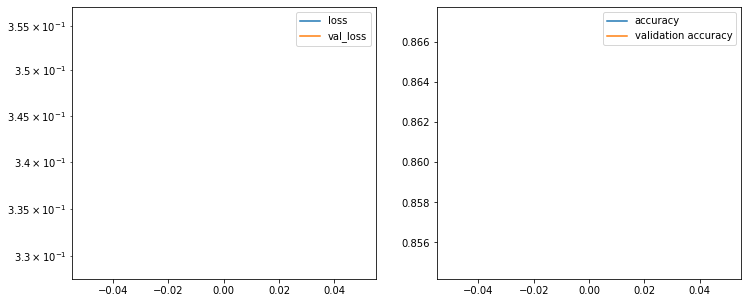

Epoch 2/1000
26942/26942 [==============================] - 1s 44us/step - loss: 0.3053 - accuracy: 0.8747 - lr: 0.0020 - val_loss: 0.2910 - val_accuracy: 0.8808 - val_lr: 0.0020

Epoch 00002: val_loss improved from 0.32892 to 0.29102, saving model to /content/drive/My Drive/AAA THESIS/Models/1_weights_temp.hdf5


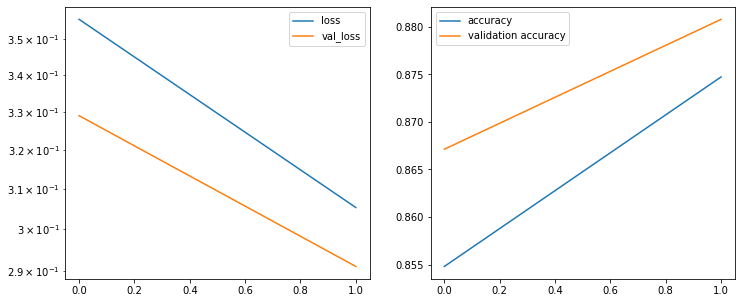

Epoch 3/1000
26942/26942 [==============================] - 1s 45us/step - loss: 0.3016 - accuracy: 0.8762 - lr: 0.0020 - val_loss: 0.2858 - val_accuracy: 0.8824 - val_lr: 0.0020

Epoch 00003: val_loss improved from 0.29102 to 0.28579, saving model to /content/drive/My Drive/AAA THESIS/Models/1_weights_temp.hdf5


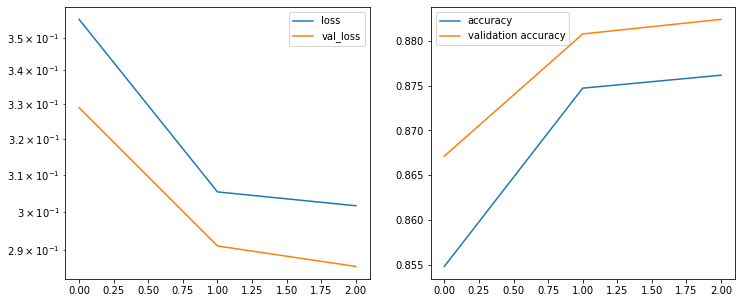

Epoch 4/1000
26942/26942 [==============================] - 1s 45us/step - loss: 0.2949 - accuracy: 0.8790 - lr: 0.0020 - val_loss: 0.2866 - val_accuracy: 0.8823 - val_lr: 0.0020

Epoch 00004: val_loss did not improve from 0.28579


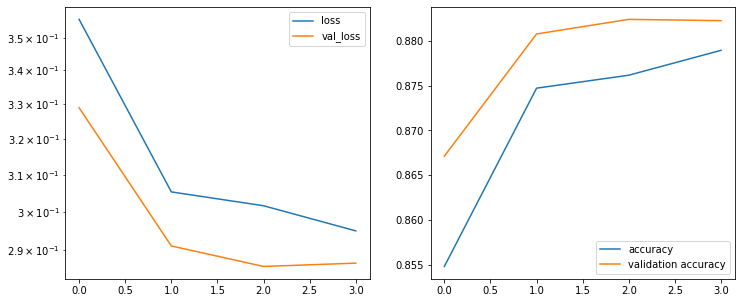

Epoch 5/1000
26942/26942 [==============================] - 1s 46us/step - loss: 0.2910 - accuracy: 0.8791 - lr: 0.0020 - val_loss: 0.2873 - val_accuracy: 0.8805 - val_lr: 0.0020

Epoch 00005: val_loss did not improve from 0.28579


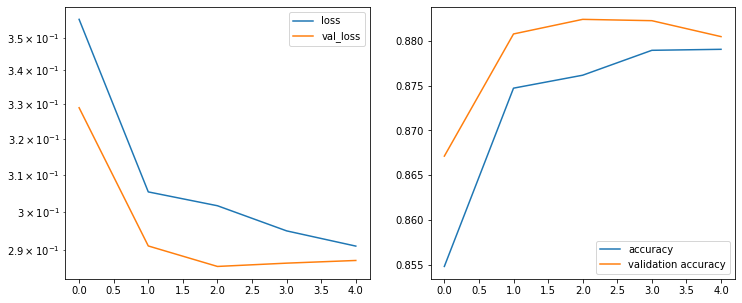

Epoch 6/1000
26942/26942 [==============================] - 1s 46us/step - loss: 0.2907 - accuracy: 0.8801 - lr: 0.0020 - val_loss: 0.2887 - val_accuracy: 0.8812 - val_lr: 0.0020

Epoch 00006: val_loss did not improve from 0.28579


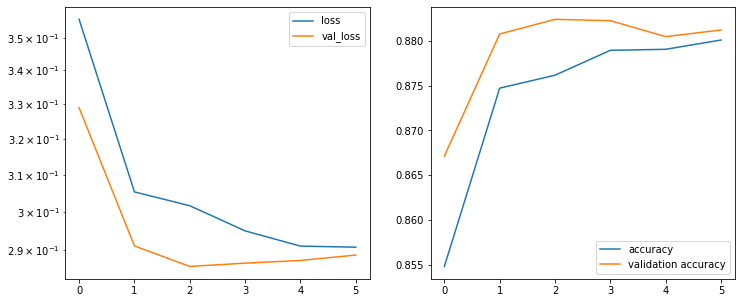

Epoch 7/1000
26942/26942 [==============================] - 1s 45us/step - loss: 0.2872 - accuracy: 0.8829 - lr: 0.0020 - val_loss: 0.2865 - val_accuracy: 0.8832 - val_lr: 0.0020

Epoch 00007: val_loss did not improve from 0.28579


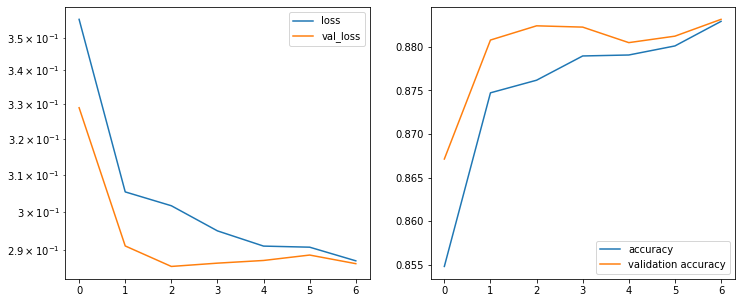

Epoch 8/1000
26942/26942 [==============================] - 1s 45us/step - loss: 0.2862 - accuracy: 0.8823 - lr: 0.0020 - val_loss: 0.2865 - val_accuracy: 0.8805 - val_lr: 0.0020

Epoch 00008: val_loss did not improve from 0.28579


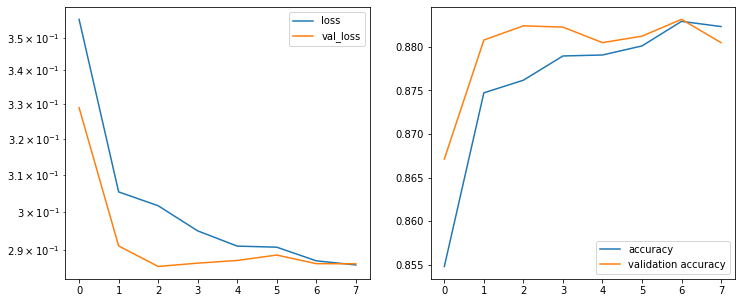

Epoch 9/1000
26942/26942 [==============================] - 1s 46us/step - loss: 0.2868 - accuracy: 0.8829 - lr: 0.0020 - val_loss: 0.2864 - val_accuracy: 0.8824 - val_lr: 0.0020

Epoch 00009: val_loss did not improve from 0.28579


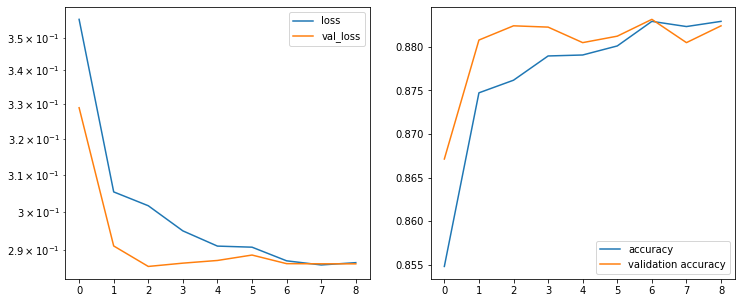

Epoch 10/1000
26942/26942 [==============================] - 1s 45us/step - loss: 0.2840 - accuracy: 0.8831 - lr: 0.0020 - val_loss: 0.2870 - val_accuracy: 0.8821 - val_lr: 0.0020

Epoch 00010: val_loss did not improve from 0.28579


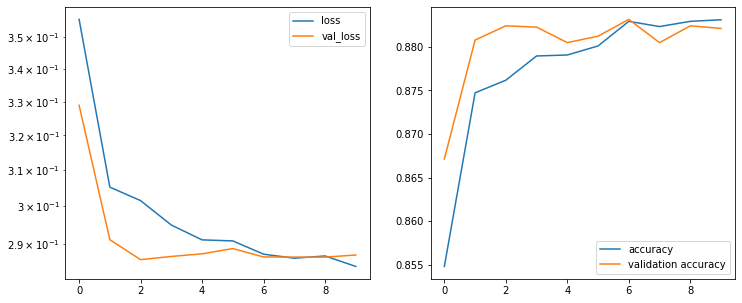

Epoch 11/1000
26942/26942 [==============================] - 1s 46us/step - loss: 0.2835 - accuracy: 0.8836 - lr: 0.0020 - val_loss: 0.2876 - val_accuracy: 0.8792 - val_lr: 0.0020

Epoch 00011: val_loss did not improve from 0.28579


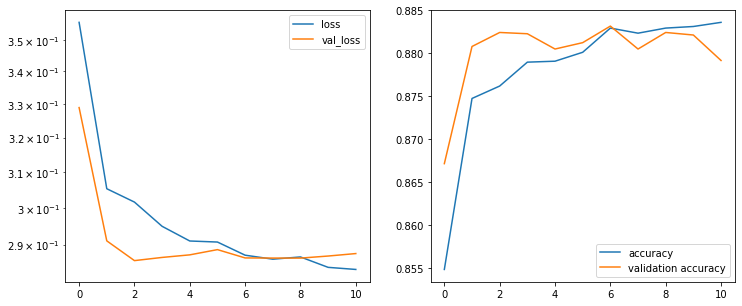

Epoch 12/1000
26942/26942 [==============================] - 1s 46us/step - loss: 0.2808 - accuracy: 0.8850 - lr: 0.0020 - val_loss: 0.2888 - val_accuracy: 0.8815 - val_lr: 0.0020

Epoch 00012: val_loss did not improve from 0.28579


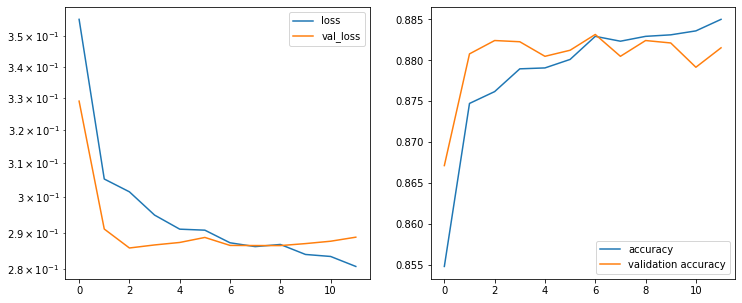

Epoch 13/1000
26942/26942 [==============================] - 1s 46us/step - loss: 0.2795 - accuracy: 0.8856 - lr: 0.0020 - val_loss: 0.2868 - val_accuracy: 0.8823 - val_lr: 0.0020

Epoch 00013: val_loss did not improve from 0.28579


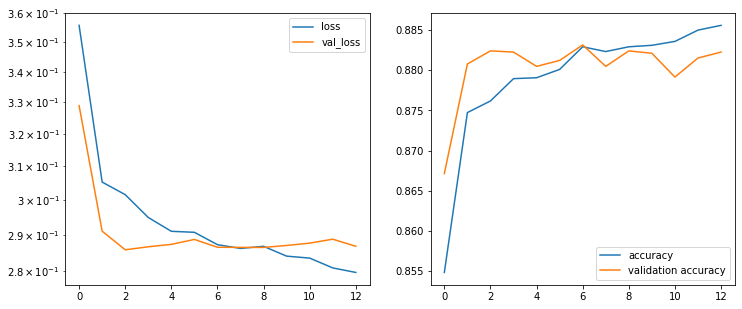

Epoch 14/1000
26942/26942 [==============================] - 1s 46us/step - loss: 0.2778 - accuracy: 0.8859 - lr: 0.0020 - val_loss: 0.2878 - val_accuracy: 0.8811 - val_lr: 0.0020

Epoch 00014: val_loss did not improve from 0.28579


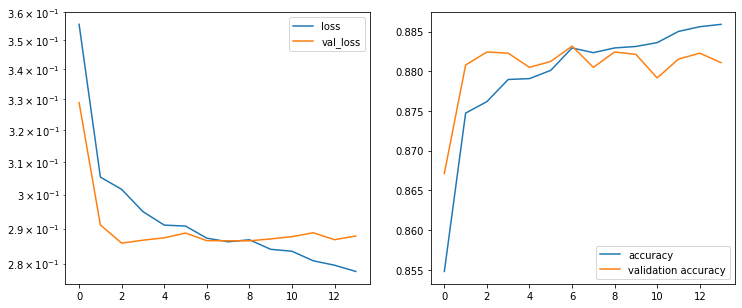

Epoch 15/1000
26942/26942 [==============================] - 1s 45us/step - loss: 0.2774 - accuracy: 0.8856 - lr: 0.0020 - val_loss: 0.2858 - val_accuracy: 0.8830 - val_lr: 0.0020

Epoch 00015: val_loss improved from 0.28579 to 0.28576, saving model to /content/drive/My Drive/AAA THESIS/Models/1_weights_temp.hdf5


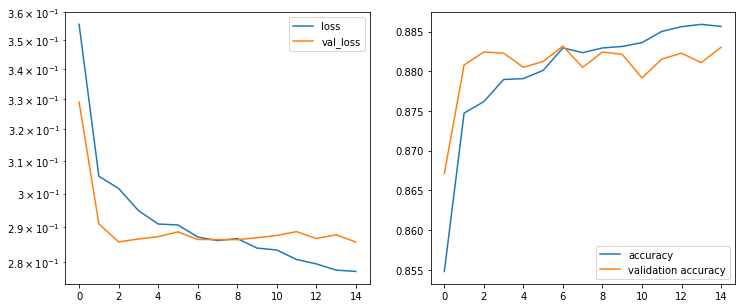

Epoch 16/1000
26942/26942 [==============================] - 1s 44us/step - loss: 0.2763 - accuracy: 0.8869 - lr: 0.0020 - val_loss: 0.2885 - val_accuracy: 0.8805 - val_lr: 0.0020

Epoch 00016: val_loss did not improve from 0.28576


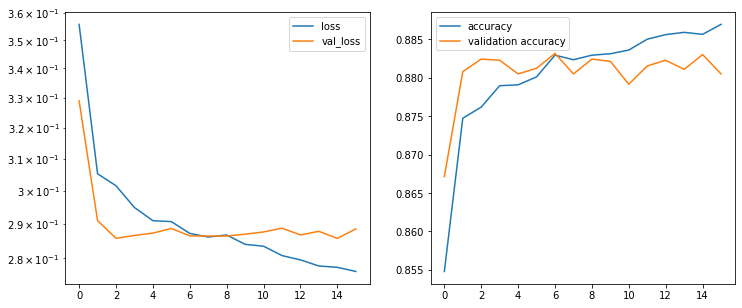

Epoch 17/1000
26942/26942 [==============================] - 1s 45us/step - loss: 0.2762 - accuracy: 0.8861 - lr: 0.0020 - val_loss: 0.2879 - val_accuracy: 0.8821 - val_lr: 0.0020

Epoch 00017: val_loss did not improve from 0.28576


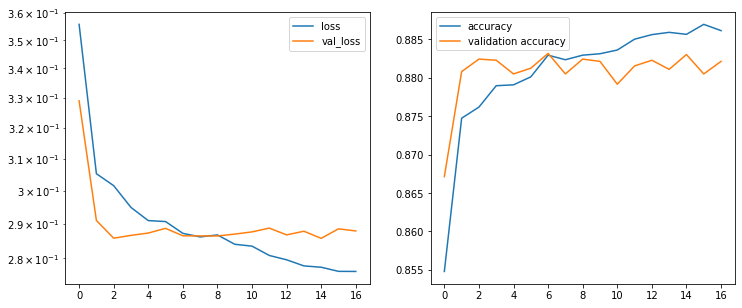

Epoch 18/1000
26942/26942 [==============================] - 1s 45us/step - loss: 0.2734 - accuracy: 0.8894 - lr: 0.0020 - val_loss: 0.2884 - val_accuracy: 0.8802 - val_lr: 0.0020

Epoch 00018: val_loss did not improve from 0.28576


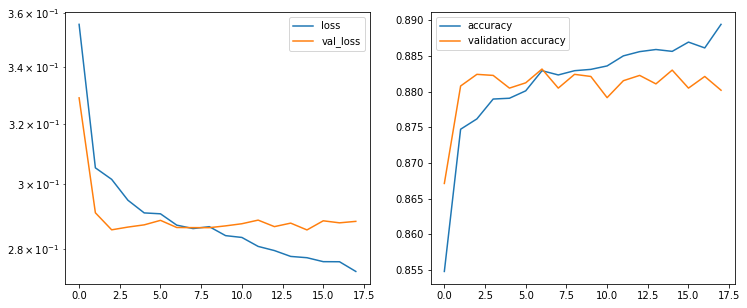

Epoch 19/1000
26942/26942 [==============================] - 1s 45us/step - loss: 0.2720 - accuracy: 0.8882 - lr: 0.0020 - val_loss: 0.2875 - val_accuracy: 0.8823 - val_lr: 0.0020

Epoch 00019: val_loss did not improve from 0.28576


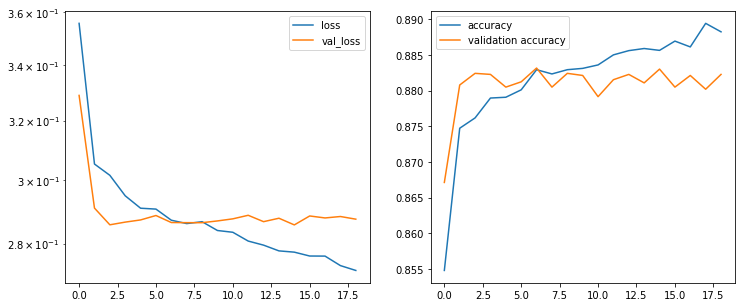

Epoch 20/1000
26942/26942 [==============================] - 1s 44us/step - loss: 0.2709 - accuracy: 0.8880 - lr: 0.0020 - val_loss: 0.2907 - val_accuracy: 0.8814 - val_lr: 0.0020

Epoch 00020: val_loss did not improve from 0.28576


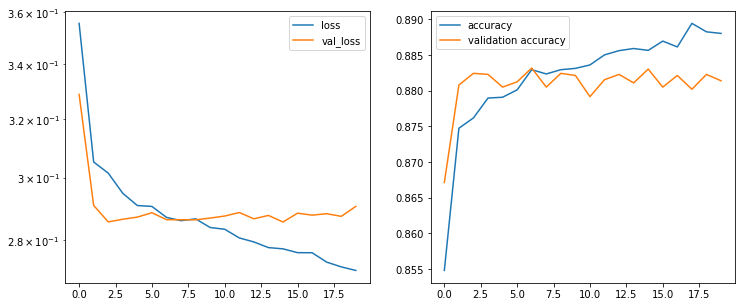

Epoch 21/1000
26942/26942 [==============================] - 1s 45us/step - loss: 0.2710 - accuracy: 0.8875 - lr: 0.0020 - val_loss: 0.2889 - val_accuracy: 0.8820 - val_lr: 0.0020

Epoch 00021: val_loss did not improve from 0.28576


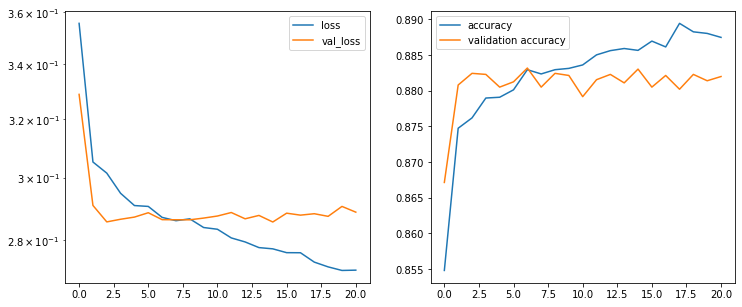

Epoch 22/1000
26942/26942 [==============================] - 1s 44us/step - loss: 0.2684 - accuracy: 0.8912 - lr: 0.0020 - val_loss: 0.2901 - val_accuracy: 0.8793 - val_lr: 0.0020

Epoch 00022: val_loss did not improve from 0.28576


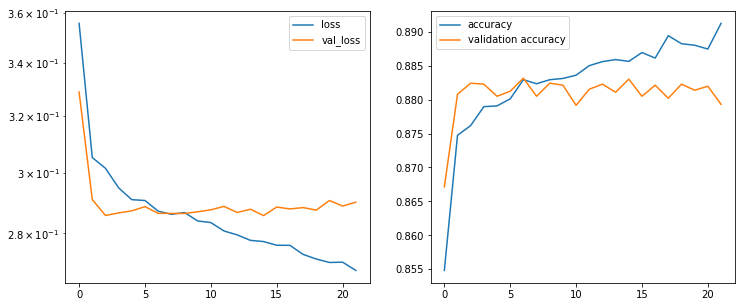

Epoch 23/1000
26942/26942 [==============================] - 1s 44us/step - loss: 0.2676 - accuracy: 0.8901 - lr: 0.0020 - val_loss: 0.2928 - val_accuracy: 0.8790 - val_lr: 0.0020

Epoch 00023: val_loss did not improve from 0.28576


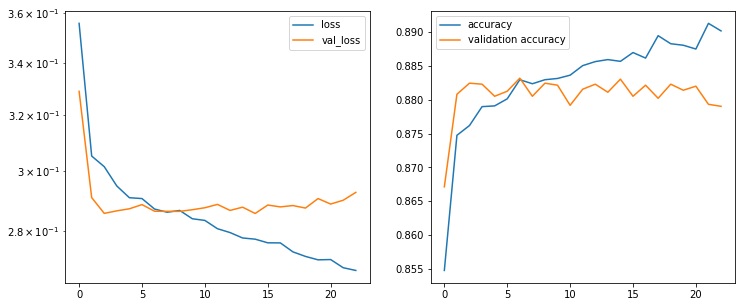

Epoch 24/1000
26942/26942 [==============================] - 1s 46us/step - loss: 0.2669 - accuracy: 0.8914 - lr: 0.0020 - val_loss: 0.2906 - val_accuracy: 0.8811 - val_lr: 0.0020

Epoch 00024: val_loss did not improve from 0.28576


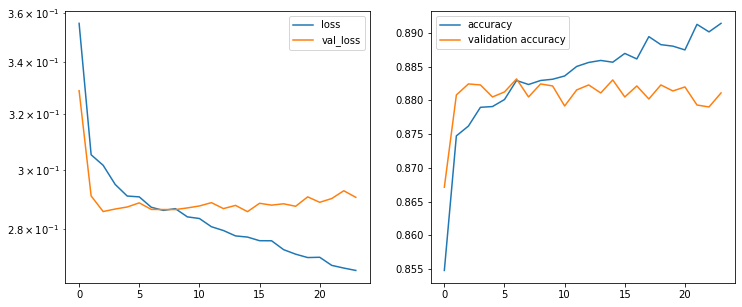

Epoch 25/1000
26942/26942 [==============================] - 1s 44us/step - loss: 0.2662 - accuracy: 0.8924 - lr: 0.0020 - val_loss: 0.2889 - val_accuracy: 0.8833 - val_lr: 0.0020

Epoch 00025: val_loss did not improve from 0.28576


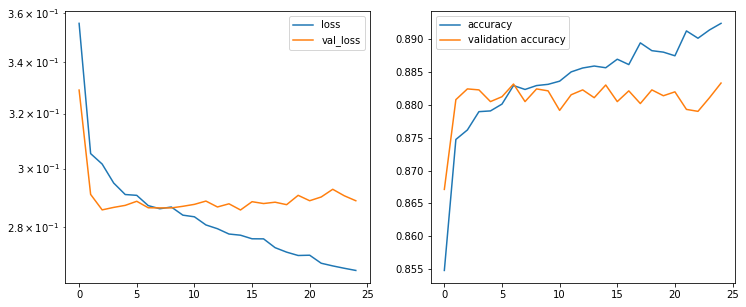

Epoch 26/1000
26942/26942 [==============================] - 1s 45us/step - loss: 0.2655 - accuracy: 0.8916 - lr: 0.0020 - val_loss: 0.2910 - val_accuracy: 0.8802 - val_lr: 0.0020

Epoch 00026: val_loss did not improve from 0.28576


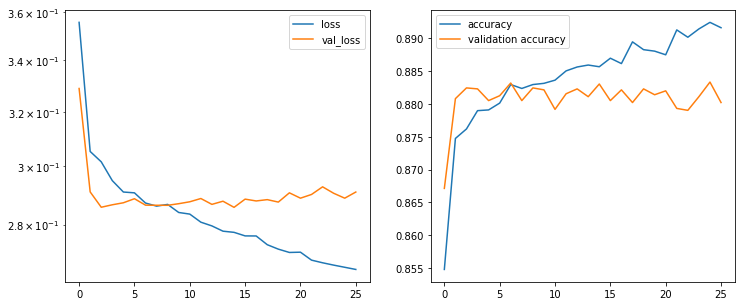

Epoch 27/1000
26942/26942 [==============================] - 1s 44us/step - loss: 0.2647 - accuracy: 0.8917 - lr: 0.0020 - val_loss: 0.2932 - val_accuracy: 0.8809 - val_lr: 0.0020

Epoch 00027: val_loss did not improve from 0.28576


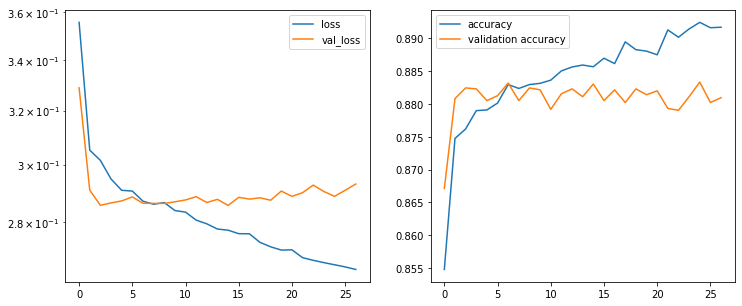

Epoch 28/1000
26942/26942 [==============================] - 1s 44us/step - loss: 0.2631 - accuracy: 0.8923 - lr: 0.0020 - val_loss: 0.2939 - val_accuracy: 0.8778 - val_lr: 0.0020

Epoch 00028: val_loss did not improve from 0.28576


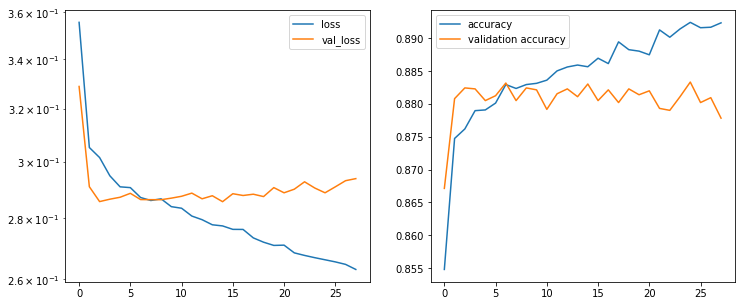

Epoch 29/1000
26942/26942 [==============================] - 1s 45us/step - loss: 0.2629 - accuracy: 0.8925 - lr: 0.0020 - val_loss: 0.2903 - val_accuracy: 0.8812 - val_lr: 0.0020

Epoch 00029: val_loss did not improve from 0.28576


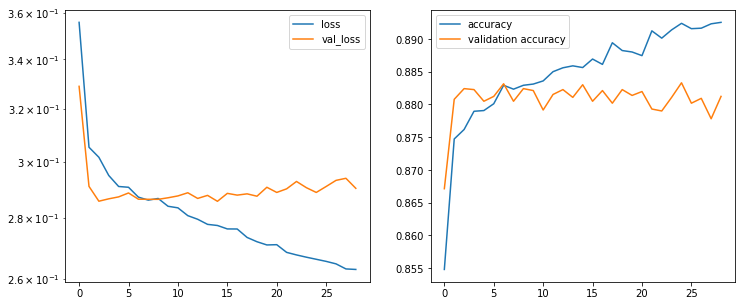

Epoch 30/1000
26942/26942 [==============================] - 1s 45us/step - loss: 0.2595 - accuracy: 0.8950 - lr: 0.0020 - val_loss: 0.2952 - val_accuracy: 0.8781 - val_lr: 0.0020

Epoch 00030: val_loss did not improve from 0.28576


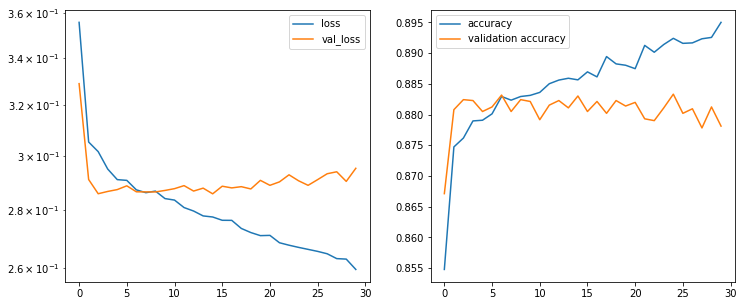

Epoch 31/1000
26942/26942 [==============================] - 1s 44us/step - loss: 0.2601 - accuracy: 0.8954 - lr: 0.0020 - val_loss: 0.2942 - val_accuracy: 0.8799 - val_lr: 0.0020

Epoch 00031: val_loss did not improve from 0.28576


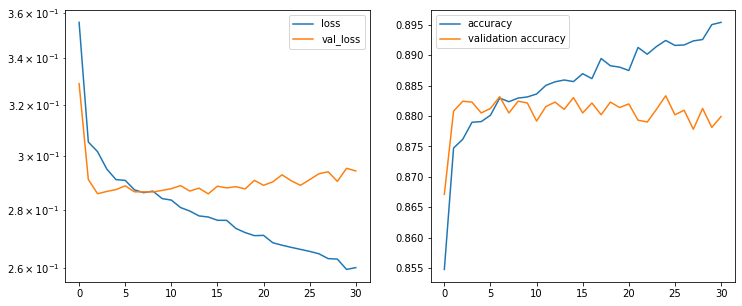

Epoch 32/1000
26942/26942 [==============================] - 1s 45us/step - loss: 0.2597 - accuracy: 0.8959 - lr: 0.0020 - val_loss: 0.2960 - val_accuracy: 0.8792 - val_lr: 0.0020

Epoch 00032: val_loss did not improve from 0.28576


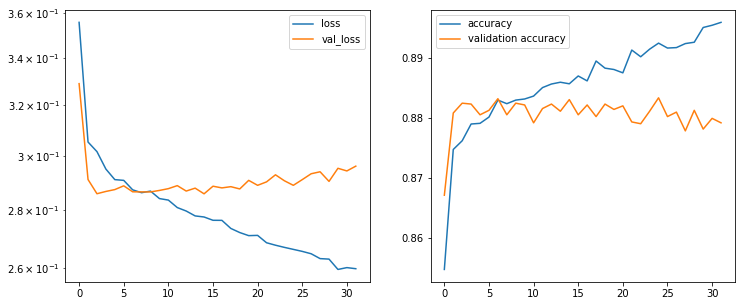

Epoch 33/1000
26942/26942 [==============================] - 1s 45us/step - loss: 0.2602 - accuracy: 0.8935 - lr: 0.0020 - val_loss: 0.2931 - val_accuracy: 0.8798 - val_lr: 0.0020

Epoch 00033: val_loss did not improve from 0.28576


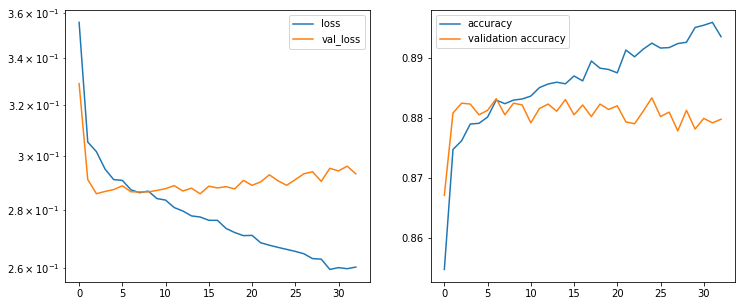

Epoch 00033: early stopping
Test Result:

accuracy score: 0.4840

Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.42      0.58     16901
           1       0.21      0.81      0.33      3099

    accuracy                           0.48     20000
   macro avg       0.57      0.62      0.45     20000
weighted avg       0.81      0.48      0.54     20000



Predicted 
  NonDef  Def
 [[7157 9744]
 [ 575 2524]]

In percentages 
  NonDef  Def
 [[0.36 0.49]
 [0.03 0.13]]

 ['loss', 'accuracy', 'lr']
[2.24290352974087, 0.4840500056743622, 0.0020000373478978872]

#################### The baseline ######################## 
accuracy is:  0.84505 
               precision    recall  f1-score   support

           0       0.85      1.00      0.92     16901
           1       0.00      0.00      0.00      3099

    accuracy                           0.85     20000
   macro avg       0.42      0.50      0.46     20000
weighted avg       0

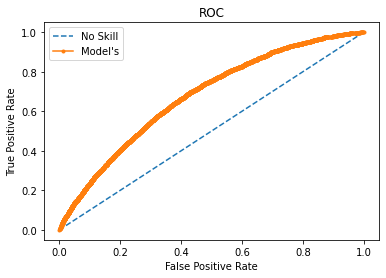

The model was dw, param = 20, shape = (26942, 118), epochs = 2, patience = 30, resampling = iht, interactions = 0, norm = 1, sample = 100,000
Model run time: 1.1 min
Time from beginning is : 1.5 min


In [0]:
# Original model by Bastani et al. (2019)
model_start = time.time()

model_orig, es, check = create_model_api(learn_rate = 0.002, drop = 0.2, size = 100, layers = 3, embed_type=8)

if fit_model:
    # keras.backend.get_session().run(tf.global_variables_initializer())
    history  =  model_orig.fit(X_train_enc, y_train, validation_data = (X_val_enc, y_val), 
                        epochs =  1000, batch_size = 100, callbacks = [check, es, plot_losses], shuffle = True)
    model_orig.load_weights(temp_weight_path, by_name=False)
    # save history and weights
    # model.save_weights("/content/drive/My Drive/AAA THESIS/Models/wd_model_weights.hdf5")
    # pd.DataFrame(history.history).to_csv('/content/drive/My Drive/AAA THESIS/Models/hist_df.csv')
    # model.save_weights("/content/drive/My Drive/AAA THESIS/Models/wd_model_weights {}.hdf5".format(datetime.now().strftime("%d.%m.%Y %H:%M:%S")))
    # pd.DataFrame(history.history).to_csv('/content/drive/My Drive/AAA THESIS/Models/hist_df {}.csv'.format(datetime.now().strftime("%d.%m.%Y %H:%M:%S")))
else:
    if scale:
        model_orig.load_weights(model_weights_norm, by_name=False)
        history = pd.read_csv(model_history_norm)
    else:
        model_orig.load_weights(model_weights, by_name=False)
        history = pd.read_csv(model_history)
    plot_history(history)

auc_orig = print_score_nn(model_orig, X_train_enc, y_train, X_test_enc, y_test, border = 0.5)
print(show_type())

# beep(tune = 'beep', email = 0,
#      subject = "fin AUC " + str(round(auc_orig, 3)) + ", " + comment,
#      body = show_type() + '. Run time: {} min'.format(round((time.time() - model_start)/60, 1)) + " : " + comment)

time_orig = round((time.time() - model_start)/60, 1)
print('Model run time: {} min'.format(time_orig))
print('Time from beginning is : {} min'.format(round((time.time() - start)/60, 1)))

In [0]:
# plot_model(model, show_shapes = True, expand_nested=False)

Creating model...
Using the W&D model
The model was dw, param = 20, shape = (26942, 118), epochs = 2, patience = 30, resampling = iht, interactions = 0, norm = 1, sample = 100,000
Train on 26942 samples, validate on 6736 samples
Epoch 1/2
26942/26942 [==============================] - 13s 493us/step - loss: 0.6081 - accuracy: 0.6786 - lr: 4.9999e-05 - val_loss: 0.5013 - val_accuracy: 0.8042 - val_lr: 5.0001e-05

Epoch 00001: val_loss improved from inf to 0.50131, saving model to /content/drive/My Drive/AAA THESIS/Models/1_weights_temp.hdf5


<Figure size 432x288 with 0 Axes>

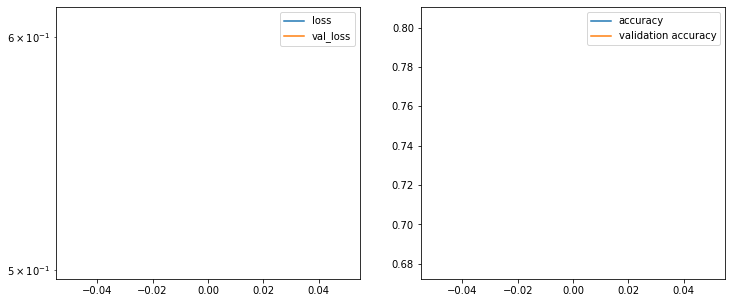

Epoch 2/2
26942/26942 [==============================] - 17s 618us/step - loss: 0.4624 - accuracy: 0.8195 - lr: 4.9999e-05 - val_loss: 0.3751 - val_accuracy: 0.8738 - val_lr: 5.0001e-05

Epoch 00002: val_loss improved from 0.50131 to 0.37511, saving model to /content/drive/My Drive/AAA THESIS/Models/1_weights_temp.hdf5


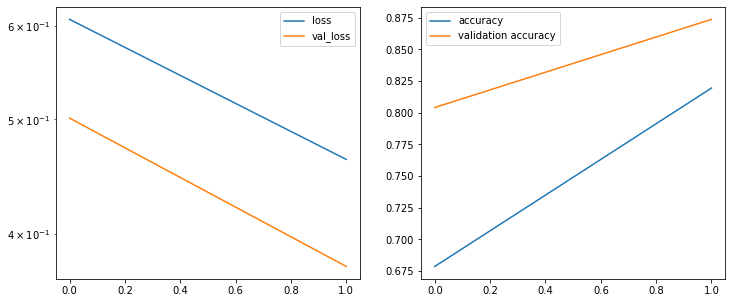

Test Result:

accuracy score: 0.5028

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.45      0.60     16901
           1       0.21      0.79      0.33      3099

    accuracy                           0.50     20000
   macro avg       0.56      0.62      0.47     20000
weighted avg       0.81      0.50      0.56     20000



Predicted 
  NonDef  Def
 [[7611 9290]
 [ 654 2445]]

In percentages 
  NonDef  Def
 [[0.38 0.46]
 [0.03 0.12]]

 ['loss', 'accuracy', 'lr']
[0.9070921980887652, 0.5027999877929688, 5.000070086680353e-05]

#################### The baseline ######################## 
accuracy is:  0.84505 
               precision    recall  f1-score   support

           0       0.85      1.00      0.92     16901
           1       0.00      0.00      0.00      3099

    accuracy                           0.85     20000
   macro avg       0.42      0.50      0.46     20000
weighted avg       0.71      0.85      0.77   

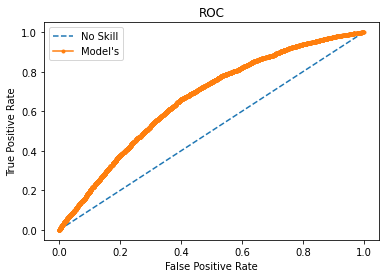

The model was dw, param = 20, shape = (26942, 118), epochs = 2, patience = 30, resampling = iht, interactions = 0, norm = 1, sample = 100,000
Model run time: 0.7 min
Time from beginning is : 2.1 min


In [0]:
# Modified model
model_start = time.time()

model_mine, es, check = create_model_api(learn_rate = 0.00005, drop = 0.4, size = 200, layers = 3)

if fit_model:
    # keras.backend.get_session().run(tf.global_variables_initializer())
    history  =  model_mine.fit(X_train_enc, y_train, validation_data = (X_val_enc, y_val), 
                        epochs =  epochs, batch_size = 8, callbacks = [check, es, plot_losses], shuffle = True)
    model_mine.load_weights(temp_weight_path, by_name=False)
    # save history and weights
    # model_mine.save_weights("/content/drive/My Drive/AAA THESIS/Models/wd_model_weights.hdf5")
    # pd.DataFrame(history.history).to_csv('/content/drive/My Drive/AAA THESIS/Models/hist_df.csv')
    # model_mine.save_weights("/content/drive/My Drive/AAA THESIS/Models/wd_model_weights {}.hdf5".format(datetime.now().strftime("%d.%m.%Y %H:%M:%S")))
    # pd.DataFrame(history.history).to_csv('/content/drive/My Drive/AAA THESIS/Models/hist_df {}.csv'.format(datetime.now().strftime("%d.%m.%Y %H:%M:%S")))
else:
    if scale:
        model_mine.load_weights(model_weights_norm, by_name=False)
        history = pd.read_csv(model_history_norm)
    else:
        model_mine.load_weights(model_weights, by_name=False)
        history = pd.read_csv(model_history)
    plot_history(history)

auc_mine = print_score_nn(model_mine, X_train_enc, y_train, X_test_enc, y_test, border = 0.5)
print(show_type())

# beep(email = 0, tune = "beep",
#      subject = "fin AUC " + str(round(auc_mine, 3)) + ", " + comment,
#      body = show_type() + '. Run time: {} min'.format(round((time.time() - model_start)/60, 1)) + " : " + comment)

time_mine = round((time.time() - model_start)/60, 1)
print('Model run time: {} min'.format(time_mine))
print('Time from beginning is : {} min'.format(round((time.time() - start)/60, 1)))

# **SHAP interpretation**

In [0]:
if stop_before_shap:
    a = fdjbfkdbv
!pip install shap
import shap

     |████████████████████████████████| 276kB 8.6MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394116 sha256=d44aa0532ab2efbced03c9fdc0d823fd7d3a082b46b2288a01fff8140699dffb
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [0]:
# calculating feature importances of the original model
model_shap = model_orig

np.random.seed(1)

shap_train = X_train_enc.loc[np.random.choice(X_train_enc.shape[0], 100, replace=False), :]   # back to 500
shap_test = X_test_enc.loc[:199, :]
print(shap_train.shape, shap_test.shape)

if model_type == 'wide':
    # ##### as KernelExplainer
    print('Calculating SHAP values:')
    explainer = shap.KernelExplainer(model_shap.predict, shap_train)
    shap_values = explainer.shap_values(shap_test, nsamples = 100)  # 11min 33s for 200 vals
else:
    ##### as DeepExplainer
    explainer = shap.DeepExplainer(model_shap, shap_train)
    print('Calculating SHAP values:')
    shap_values = explainer.shap_values(np.array(shap_test.iloc[:200, :]))
    shap_df = pd.DataFrame(shap_values[0])   # all shap values of first 200 observations

shap_df = pd.DataFrame(shap_values[0])   # all shap values of first 200 observations
shap_df.columns = X_train_enc.columns
shap_test.columns = X_test_enc.columns
shap_df = rename_variables(shap_df)
shap_test = rename_variables(shap_test)

vals= np.abs(shap_values).mean(0)/2
feature_importance = pd.DataFrame(list(zip(shap_df.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
print()
print('Orig AUC:', round(auc_orig, 3))
print('Mine AUC:', round(auc_mine, 3))
print('Orig time:', time_orig)
print('Mine time:', time_mine)

feature_importance.head(20)

(100, 118) (200, 118)

Calculating SHAP values:

Orig AUC: 0.678
Mine AUC: 0.663
Orig time: 1.1
Mine time: 0.7

!!!!!!!! ORIGINAL !!!!!!!!!!!


col_name  feature_importance_vals
11                                           Sub grade                    14.39
8                   Loan amount to annual income ratio                     6.28
0                                        Annual income                     4.25
6             Number of open accounts in credit report                     3.93
13                                   FICO credit score                     3.69
3                           Inquiries in last 6 months                     2.77
9            Annual installment to annual income ratio                     2.69
15                         Lending Club credit grade C                     2.41
10                                Debt to Income ratio                     2.29
1         Time from first credit line in credit report                     2.01
106                               Home ownership: RENT                     1.77
5                              Credit utilization rate                     1.51
7    Number of months since borrowers last delinquency                     1.36
16                         Lending Club credit grade D                     1.33
23                     Lending Club credit subgrade A5                     1.33
4          Number of derogatory marks in credit report                     1.15
2      Number of 30+ day delinquencies in past 2 years                     0.95
22                     Lending Club credit subgrade A4                     0.91
12                                 Purpose of the loan                     0.86
17                         Lending Club credit grade E                     0.82

###Data Preparation

In [0]:
%%time
model_shap = model_mine  # model_mine model_orig

np.random.seed(1)

shap_train = X_train_enc.loc[np.random.choice(X_train_enc.shape[0], 100, replace=False), :]   # back to 500
shap_test = X_test_enc.loc[:199, :]
print(shap_train.shape, shap_test.shape)

if model_type == 'wide':
    # ##### as KernelExplainer
    print('Calculating SHAP values witk KernelExplainer:')
    explainer = shap.KernelExplainer(model_shap.predict, shap_train)
    shap_values = explainer.shap_values(shap_test, nsamples = 100)  # 11min 33s for 200 vals
else:
    ##### as DeepExplainer
    explainer = shap.DeepExplainer(model_shap, shap_train)
    print('Calculating SHAP values with DeepExplainer:')
    shap_values = explainer.shap_values(np.array(shap_test.iloc[:200, :]))
    shap_df = pd.DataFrame(shap_values[0])   # all shap values of first 200 observations

(100, 118) (200, 118)
Calculating SHAP values with DeepExplainer:
CPU times: user 10.5 s, sys: 296 ms, total: 10.8 s
Wall time: 9.19 s


In [0]:
shap_df = pd.DataFrame(shap_values[0])   # all shap values of first 200 observations
shap_df.columns = X_train_enc.columns
shap_test.columns = X_test_enc.columns
shap_df = rename_variables(shap_df)
shap_test = rename_variables(shap_test)

In [0]:
pd.concat([shap_test.iloc[:8, :16], 
           pd.Series(model_shap.predict(X_test_enc)[:, 0]).head(8)], axis = 1
          ).T.rename({0:'Prediction of default'})

0     1     2     3     4     5     6     7
Annual income                                     -0.95 -0.72 -0.77 -0.74 -0.43 -0.33 -0.24 -0.62
Time from first credit line in credit report      -1.15 -1.23 -0.47 -0.00  2.77 -0.93  0.04  0.72
Number of 30+ day delinquencies in past 2 years   -0.35 -0.35 -0.35 -0.35 -0.35 -0.35 -0.35 -0.35
Inquiries in last 6 months                        -0.65  0.43 -0.65  1.52 -0.65 -0.65  1.52 -0.65
Number of derogatory marks in credit report       -0.30 -0.30 -0.30 -0.30 -0.30 -0.30  1.86 -0.30
Credit utilization rate                           -0.74 -0.10  0.11  0.15  1.70  0.59 -1.10 -0.68
Number of open accounts in credit report          -0.25 -0.66 -0.46 -1.28  0.37  0.57  0.37  2.63
Number of months since borrowers last delinquency -0.67 -0.67  0.53  1.09  2.10  2.61 -0.67 -0.67
Loan amount to annual income ratio                -0.39  1.87  0.82  1.04  0.95  2.33 -0.45 -1.01
Annual installment to annual income ratio         -0.40  2.55  0.88  1.47  1.43  1.36 -0.37 -1.02
Debt to Income ratio                              -0.90  1.22 -0.61  2.16  0.85  1.52 -0.24  1.58
Sub grade                                          4.00 19.00  7.00 20.00 21.00 13.00  7.00  2.00
Purpose of the loan                                1.00  5.00  2.00  2.00  2.00  1.00  2.00  4.00
FICO credit score                                  6.00  7.00  2.00  8.00  2.00  5.00  7.00 11.00
Lending Club credit grade B                        0.00  0.00  1.00  0.00  0.00  0.00  1.00  0.00
Lending Club credit grade C                        0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00
Prediction of default                              0.21  0.83  0.37  0.79  0.85  0.89  0.40  0.28

In [0]:
shap_df.iloc[:8, :16].round(3).T.apply(lambda x: x*100).style.apply(lambda x:["background:orange" if v < 0 else " " for v in x], axis = 1).apply(
    lambda x:["background:lightgreen" if v > 0 else "" for v in x], axis = 1).set_precision(1)

## Regular SHAP graphs

In [0]:
observation_index = 3

# shap_values_single = explainer.shap_values(shap_test[observation_index])   # 19 sec
shap.initjs()
# shap.force_plot(explainer.expected_value[0], shap_values[0][observation_index], 
#                 shap_test.loc[observation_index, :])   # if shap_test is a DataFrame

shap.force_plot(explainer.expected_value[0], shap_df.iloc[observation_index, :].values, 
                shap_test.loc[observation_index, :])   # if shap_test is a DataFrame

SHAP feature importance is an alternative to permutation feature importance. There is a big difference between both importance measures: Permutation feature importance is based on the decrease in model performance. SHAP is based on magnitude of feature attributions.

The feature importance plot is useful, but contains no information beyond the importances.

In [0]:
vals= np.abs(shap_values).mean(0)/2
feature_importance = pd.DataFrame(list(zip(shap_df.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head(20)

col_name  feature_importance_vals
11                                           Sub grade                    13.63
6             Number of open accounts in credit report                     3.10
0                                        Annual income                     2.71
3                           Inquiries in last 6 months                     2.68
13                                   FICO credit score                     2.44
8                   Loan amount to annual income ratio                     2.04
10                                Debt to Income ratio                     1.92
1         Time from first credit line in credit report                     1.79
5                              Credit utilization rate                     1.64
2      Number of 30+ day delinquencies in past 2 years                     1.53
55             Purpose of the loan: debt_consolidation                     1.43
106                               Home ownership: RENT                     1.36
4          Number of derogatory marks in credit report                     1.29
54                    Purpose of the loan: credit_card                     1.09
107                       Employment lenght: 10+ years                     1.08
7    Number of months since borrowers last delinquency                     1.01
9            Annual installment to annual income ratio                     0.98
23                     Lending Club credit subgrade A5                     0.68
14                         Lending Club credit grade B                     0.67
104                                Home ownership: OWN                     0.63

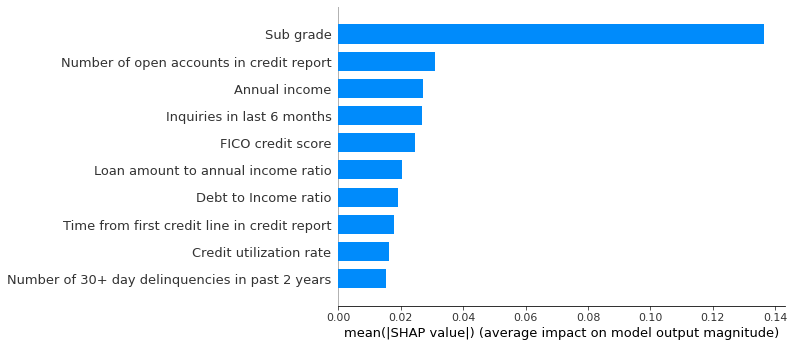

In [0]:
shap.summary_plot(shap_df, shap_test, plot_type="bar", max_display=10)

The summary plot combines feature importance with feature effects. Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. The color represents the value of the feature from low to high. Overlapping points are jittered in y-axis direction, so we get a sense of the distribution of the Shapley values per feature. The features are ordered according to their importance.

Your regular reminder: All effects describe the behavior of the model and are not necessarily causal in the real world.

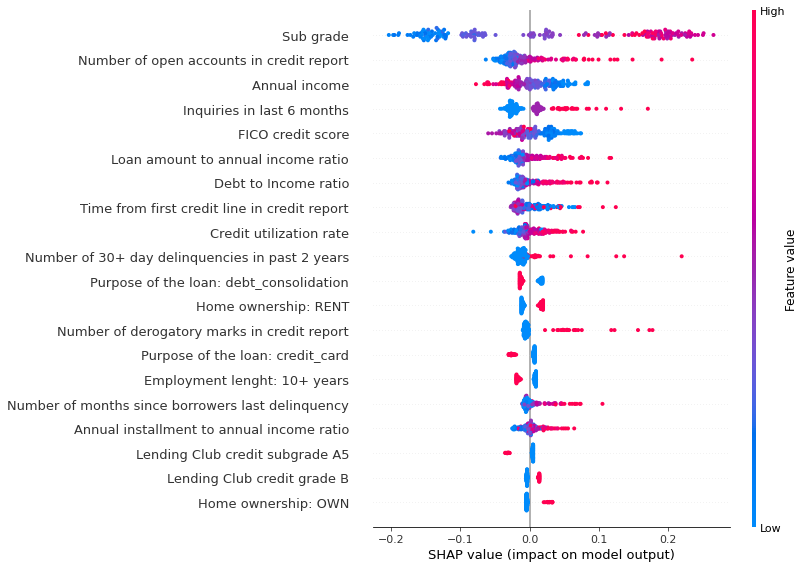

In [0]:
shap.summary_plot(shap_df.values, shap_test, max_display=20)

In [0]:
# beep(tune='beep', email = 1)
# print('Time from beginning is : {} min'.format(round((time.time() - start)/60, 1)))
# stop

SHAP feature dependence might be the simplest global interpretation plot - for each data instance, it plots a point with the feature value on the x-axis and the corresponding Shapley value on the y-axis.
Here we can see that higher values of debt-to-income are having stronger effect on the outcome (default rate). Additionally, to help reveal interactions with other features, the model selects another feauture for colouring. In this case colouring by installment-to-income shown that there is little interaction - the stronest has installment to income, but we can see just a slight skew up at higher (red) inst_to_inc values.

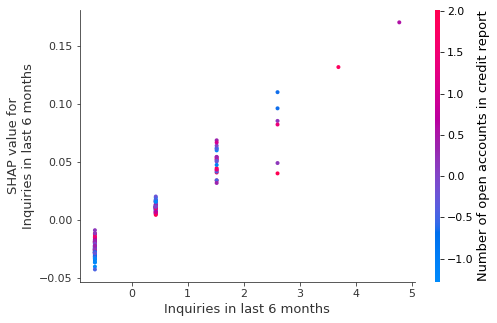

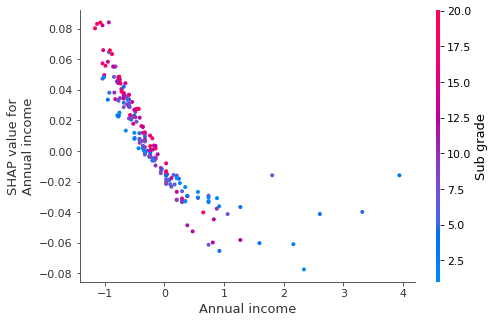

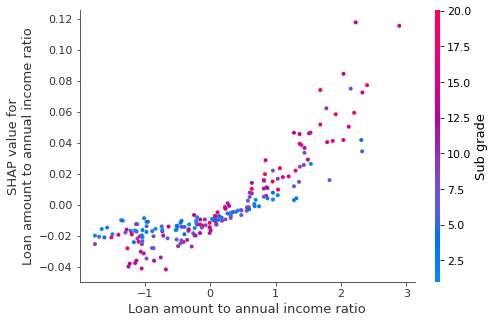

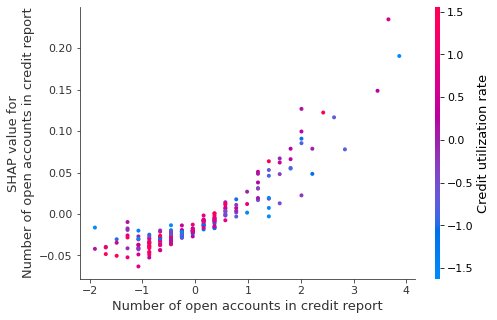

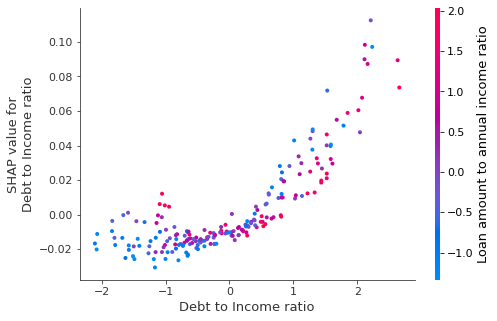

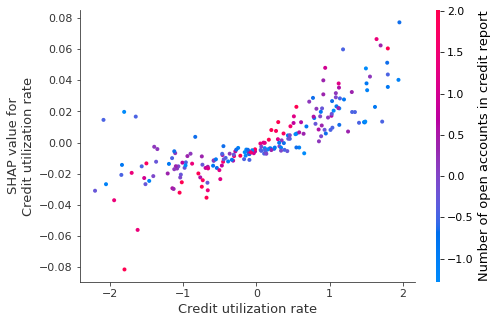

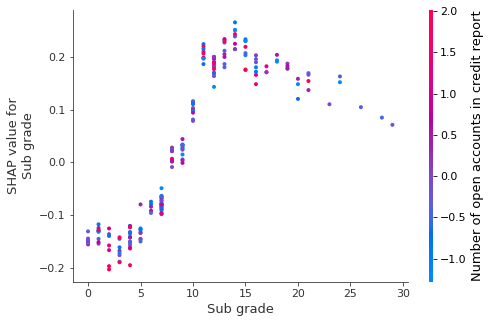

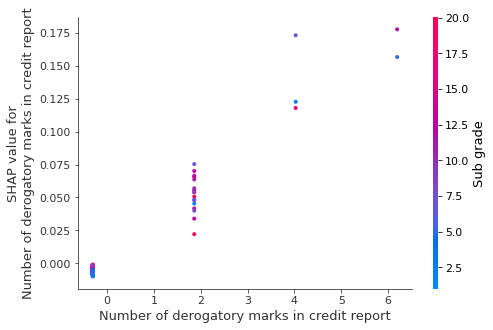

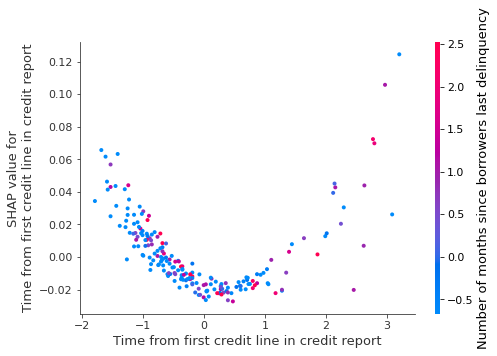

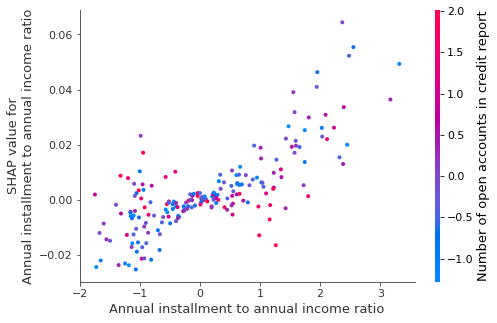

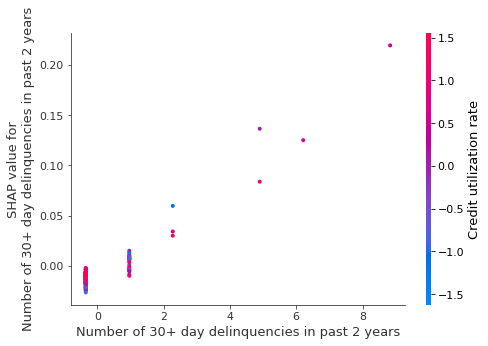

In [0]:
# shap.dependence_plot(shap_df.columns[3], shap_df.values, shap_test)     #inq_last_6mths
# shap.dependence_plot(shap_df.columns[0], shap_df.values, shap_test)     # annual_inc
# shap.dependence_plot(shap_df.columns[10], shap_df.values, shap_test)    # dti

shap.dependence_plot('Inquiries in last 6 months', shap_df.values, shap_test)     #inq_last_6mths
shap.dependence_plot('Annual income', shap_df.values, shap_test)     # annual_inc
shap.dependence_plot('Loan amount to annual income ratio', shap_df.values, shap_test)
shap.dependence_plot('Number of open accounts in credit report', shap_df.values, shap_test)
shap.dependence_plot('Debt to Income ratio', shap_df.values, shap_test)
shap.dependence_plot('Credit utilization rate', shap_df.values, shap_test)
shap.dependence_plot('Sub grade', shap_df.values, shap_test)
shap.dependence_plot('Number of derogatory marks in credit report', shap_df.values, shap_test)
shap.dependence_plot('Time from first credit line in credit report', shap_df.values, shap_test)
shap.dependence_plot('Annual installment to annual income ratio', shap_df.values, shap_test)
shap.dependence_plot('Number of 30+ day delinquencies in past 2 years', shap_df.values, shap_test)
# shap.dependence_plot('Lending Club credit grade A', shap_df.values, shap_test)

if interactions:
    shap.dependence_plot('C(fico_buckets_bast)[T.(800, 805]]:C(purpose)[T.debt_consolidation]', shap_df.values, shap_test)
    shap.dependence_plot('C(fico_buckets_bast)[T.(665, 670]]:C(purpose)[T.debt_consolidation]', shap_df.values, shap_test)
    shap.dependence_plot('C(fico_buckets_bast)[T.(710, 715]]:C(purpose)[T.medical]', shap_df.values, shap_test)

You can cluster your data with the help of Shapley values. The goal of clustering is to find groups of similar instances. Normally, clustering is based on features.

Stacked SHAP explanations clustered by explanation similarity. Each position on the x-axis is an instance of the data. Red SHAP values increase the prediction, blue values decrease it. We see that grades have the dominant effect, but at some clusters loan_to_inc, inquieriesin 6 mnths or DTI can have increasing influence.

In [0]:
# # plot the feature attributions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_df.values, shap_test)

## SHAP2prob

In [0]:
# shap_sum = shap_df.loc[:, :150].sum(axis = 1)
shap_sum = shap_df.sum(axis = 1)

temp_val = shap_df.head(20).round(2)
# temp_val = rename_variables(temp_val, index = 0)
(temp_val*100).style.apply(lambda x:["background:red" if v < 0 else " " for v in x], axis = 1).apply(
    lambda x:["background:lightgreen" if v > 0 else "" for v in x], axis = 1).set_precision(0)
    # [i for i in temp.columns if ((len(i) >= 15) & (']:C' not in i))]

In [0]:
a = (temp_val*100).iloc[11:15, [0, 5, 10, 11]]
a.iloc[0,0] = -7
a.iloc[0,1] = 4.6
a.iloc[0,2] = 9
a.iloc[0,3] = 3.5
a['SUM'] = a.sum(axis = 1)
a = a.rename({11:1, 12:2, 13:3, 14:4})
pd.DataFrame(a).T.style.apply(lambda x:["background:red" if v < 0 else " " for v in x], axis = 1).apply(
    lambda x:["background:lightgreen" if v > 0 else "" for v in x], axis = 1).set_precision(0)
    # [i for i in temp.columns if ((len(i) >= 15) & (']:C' not in i))]

In [0]:
# create predicted probabilities of default by the model on test data
probas_cat = pd.Series(model_shap.predict(X_test_enc)[:, 0])
print("{:,.4f}".format(probas_cat[0]))

0.2133


In [0]:
def shap2deltaprob(features, 
                   shap_df, 
                   shap_sum,
                   probas,
                   func_shap2probas):
    '''
    map shap to Δ probabilities
    --- input ---
    :features: list of strings, names of features
    :shap_df: pd.DataFrame, dataframe containing shap values
    :shap_sum: pd.Series, series containing shap sum for each observation
    :probas: pd.Series, series containing predicted probability for each observation
    :func_shap2probas: function, maps shap to probability (for example interpolation function)
    --- output ---
    :out: pd.Series or pd.DataFrame, Δ probability for each shap value
    '''
    # 1 feature
    if type(features) == str or len(features) == 1:
        return probas - (shap_sum - shap_df[features]).apply(func_shap2probas)
    # more than 1 feature
    else:
        return shap_df[features].apply(lambda x: shap_sum - x).apply(func_shap2probas).apply(lambda x: probas - x)

In [0]:
# build interpolation function to map shap into probability
shap_sum_sort = shap_sum.sort_values()
probas_cat_sort = probas_cat[shap_sum_sort.index]

intp = interp1d(x = shap_sum_sort,
                y = probas_cat_sort, 
                bounds_error = False, 
                fill_value = (0, 1))

### show Δ probabilities
temp = shap2deltaprob(features = shap_df.columns.to_list(),
                      shap_df = shap_df,
                      shap_sum = shap_sum,
                      probas = probas_cat,
                      func_shap2probas = intp).head(20).applymap(lambda x:('+'if x>0 else '')+str(round(x*100,1))+'%')

temp.style.apply(lambda x:["background:orange" if float(v[:-1]) < 0 else " " for v in x], axis = 1).apply(
    lambda x:["background:lightgreen" if float(v[:-1]) > 0 else "" for v in x], axis = 1)#.set_properties(subset=['Annual income'], **{'width': '300px'})  

In [0]:
print(shap_df.loc[0, :].min())
pd.concat([shap_sum.head(),shap_df.head()], axis = 1)

-0.15729338974546409


0  Annual income  Time from first credit line in credit report  Number of 30+ day delinquencies in past 2 years  Inquiries in last 6 months  Number of derogatory marks in credit report  Credit utilization rate  Number of open accounts in credit report  Number of months since borrowers last delinquency  Loan amount to annual income ratio  Annual installment to annual income ratio  Debt to Income ratio  Sub grade  Purpose of the loan  FICO credit score  Lending Club credit grade B  Lending Club credit grade C  Lending Club credit grade D  Lending Club credit grade E  Lending Club credit grade F  Lending Club credit grade G  Lending Club credit subgrade A2  Lending Club credit subgrade A3  Lending Club credit subgrade A4  Lending Club credit subgrade A5  Lending Club credit subgrade B1  Lending Club credit subgrade B2  Lending Club credit subgrade B3  Lending Club credit subgrade B4  Lending Club credit subgrade B5  Lending Club credit subgrade C1  Lending Club credit subgrade C2  \
0 -0.28           0.03                                          0.01                                            -0.02                       -0.02                                        -0.01                    -0.01                                     -0.02                                              -0.01                               -0.01                                      -0.01                 -0.02      -0.16                -0.01              -0.00                        -0.00                         0.00                        -0.00                         0.00                        -0.00                         0.00                             0.00                             0.00                            -0.00                            -0.03                             0.00                             0.00                            -0.00                             0.00                            -0.00                            -0.00                            -0.00   
1  0.34           0.04                                          0.04                                            -0.01                        0.01                                        -0.00                    -0.01                                     -0.02                                              -0.01                                0.04                                       0.06                  0.01       0.18                 0.01               0.01                        -0.00                         0.00                         0.01                         0.00                        -0.00                         0.00                             0.00                             0.00                            -0.00                             0.00                             0.00                             0.00                            -0.00                             0.00                            -0.00                            -0.00                            -0.00   
2 -0.12           0.03                                         -0.01                                            -0.02                       -0.03                                        -0.01                    -0.01                                     -0.03                                               0.00                                0.01                                       0.01                 -0.01      -0.10                 0.00               0.03                         0.01                         0.00                        -0.00                         0.00                        -0.00                         0.00                             0.00                             0.00                            -0.00                             0.00                             0.00                             0.00                             0.01                             0.00                            -0.00                            -0.00                            -0.00   
3 

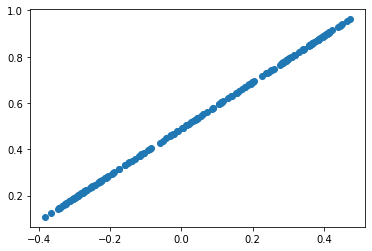

In [0]:
plt.scatter(shap_sum_sort, probas_cat_sort)
# shap_sum_sort
# probas_cat_sort

In [0]:
# feature importance
(temp_val.abs().mean().sort_values(ascending = False)/sum(temp_val.abs().mean())).head(20)

Sub grade                                           0.29
Number of open accounts in credit report            0.07
Inquiries in last 6 months                          0.06
Annual income                                       0.05
Debt to Income ratio                                0.05
FICO credit score                                   0.04
Loan amount to annual income ratio                  0.04
Time from first credit line in credit report        0.04
Purpose of the loan: credit_card                    0.03
Home ownership: RENT                                0.03
Purpose of the loan: debt_consolidation             0.03
Number of 30+ day delinquencies in past 2 years     0.02
Number of derogatory marks in credit report         0.02
Credit utilization rate                             0.02
Number of months since borrowers last delinquency   0.02
Employment lenght: 10+ years                        0.02
Annual installment to annual income ratio           0.02
Employment lenght: 3 years     

Text(0.5, 1.0, 'From SHAP to Predicted Probability')

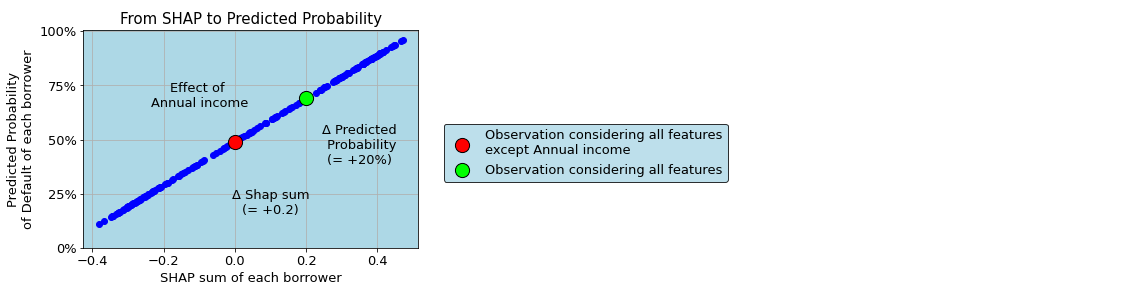

In [0]:
plt.scatter(0,intp(0),s=200,fc='red',ec='black',zorder=3,label='Observation considering all features\nexcept Annual income')
plt.scatter(0.2,intp(0.2),s=200,fc='lime',ec='black',zorder=3,label='Observation considering all features')

plt.annotate(s='',xy=(2.5,intp(2)+.5*.18),xytext=(0-.5,intp(0)+.5*.18),arrowprops={'fc':'black'})
plt.text(-0.1,.7,'Effect of \nAnnual income',ha='center',va='center',fontsize=13)

plt.annotate(s='',xy=(2,intp(0)-.5*.18),xytext=(0,intp(0)-.5*.18),arrowprops={'fc':'black'})
plt.text(0.1, 0.27,'Δ Shap sum\n(= +0.2)',ha='center',va='top',fontsize=13)

plt.annotate(s='',xy=(2+.5,intp(2)),xytext=(2+.5,intp(0)),arrowprops={'fc':'black'})
plt.text(0.35,(intp(0)+intp(0.2))/2.5,'Δ Predicted\n Probability\n(= +20%)',va='center',ha='center',fontsize=13)

legend = plt.legend(bbox_to_anchor=(1.5, .6), loc = 'upper center',fontsize=13)
frame = legend.get_frame()
frame.set_facecolor('lightblue')
frame.set_edgecolor('black')

plt.scatter(shap_sum_sort, probas_cat_sort, color='blue',zorder=2)

plt.gca().set_facecolor('lightblue')
plt.grid(zorder=1)
plt.xlabel('SHAP sum of each borrower',fontsize=13)
plt.ylabel('Predicted Probability\nof Default of each borrower',fontsize=13)
plt.xticks(fontsize=13)
plt.yticks([0,.25,.5,.75,1],['0%','25%','50%','75%','100%'],fontsize=13)
plt.title('From SHAP to Predicted Probability',fontsize=15)

Text(0.5, 1.0, 'From SHAP to Predicted Probability')

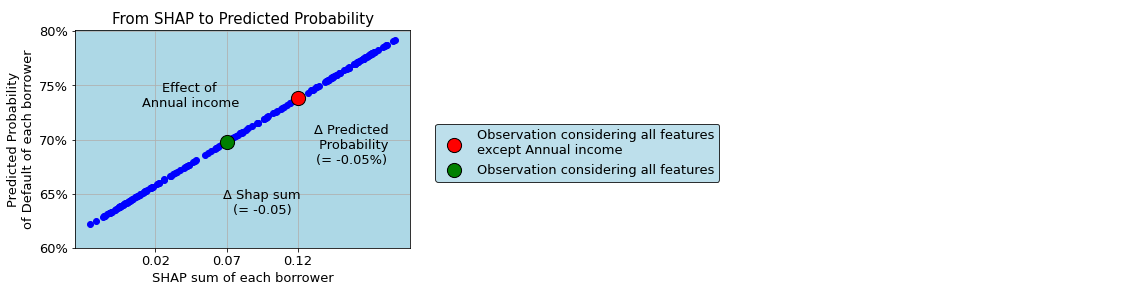

In [0]:
plt.scatter(0.2,intp(0.2),s=200,fc='red',ec='black',zorder=3,label='Observation considering all features\nexcept Annual income')
plt.scatter(0,intp(0),s=200,fc='green',ec='black',zorder=3,label='Observation considering all features')

plt.annotate(s='',xy=(2.5,intp(2)+.5*.18),xytext=(0-.5,intp(0)+.5*.18),arrowprops={'fc':'black'})
plt.text(-0.1,.7,'Effect of \nAnnual income',ha='center',va='center',fontsize=13)

plt.annotate(s='',xy=(2,intp(0)-.5*.18),xytext=(0,intp(0)-.5*.18),arrowprops={'fc':'black'})
plt.text(0.1, 0.27,'Δ Shap sum\n(= -0.05)',ha='center',va='top',fontsize=13)

plt.annotate(s='',xy=(2+.5,intp(2)),xytext=(2+.5,intp(0)),arrowprops={'fc':'black'})
plt.text(0.35,(intp(0)+intp(0.2))/2.5,'Δ Predicted\n Probability\n(= -0.05%)',va='center',ha='center',fontsize=13)

legend = plt.legend(bbox_to_anchor=(1.5, .6), loc = 'upper center',fontsize=13)
frame = legend.get_frame()
frame.set_facecolor('lightblue')
frame.set_edgecolor('black')

plt.scatter(shap_sum_sort, probas_cat_sort, color='blue',zorder=2)

plt.gca().set_facecolor('lightblue')
plt.grid(zorder=1)
plt.xlabel('SHAP sum of each borrower',fontsize=13)
plt.ylabel('Predicted Probability\nof Default of each borrower',fontsize=13)
plt.xticks([-0.2, 0, 0.2],['0.02','0.07','0.12'], fontsize=13)
plt.yticks([0,.25,.5,.75,1],['60%','65%','70%','75%','80%'],fontsize=13)
plt.title('From SHAP to Predicted Probability',fontsize=15)

In [0]:
def partial_deltaprob(feature, X, shap_df, shap_sum, probas, func_shap2probas,
                      cutoffs = None
                     ):
    '''
    return univariate analysis (count, mean and standard deviation) of shap values based on the original feature
    --- input ---
    :feature: str, name of feature
    :X: pd.Dataframe, shape (N, P)
    :shap_df: pd.DataFrame, shape (N, P)
    :shap_sum: pd.Series, series containing shap sum for each observation
    :probas: pd.Series, series containing predicted probability for each observation
    :func_shap2probas: function, maps shap to probability (for example interpolation function)
    :cutoffs: list of floats, cutoffs for numerical features
    --- output ---
    :out: pd.DataFrame, shape (n_levels, 3)
    '''
    dp_col = shap2deltaprob(feature, shap_df, shap_sum, probas, func_shap2probas)
    dp_col_mean = dp_col.mean()
    dp_col.name = 'DP_' + feature
    out = pd.concat([X[feature], dp_col], axis = 1)
    if cutoffs:
        intervals = pd.IntervalIndex.from_tuples(list(zip(cutoffs[:-1], cutoffs[1:])))
        out[feature] = pd.cut(out[feature], bins = intervals)
        out = out.dropna()   
    out = out.groupby(feature).describe().iloc[:, :3]
    out.columns = ['count', 'mean', 'std']
    out['std'] = out['std'].fillna(0)
    return out

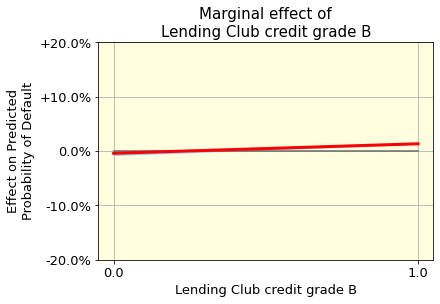

In [0]:
# categorical
var = 'Lending Club credit grade B'

dp = partial_deltaprob(var, shap_test, shap_df, shap_sum, probas_cat, func_shap2probas=intp)

plt.plot([0,len(dp)-1],[0,0],color='dimgray',zorder=3)
plt.plot(range(len(dp)), dp['mean'], color = 'red', linewidth = 3, label = 'Avg effect',zorder=4)
plt.fill_between(range(len(dp)), dp['mean'] + dp['std'], dp['mean'] - dp['std'],
                 color = 'lightskyblue', label = 'Avg effect +- StDev',zorder=1)
yticks = list(np.arange(-.2,.21,.1))
plt.yticks(yticks, [('+' if y > 0 else '') + '{0:.1%}'.format(y) for y in yticks], fontsize=13)
plt.xticks(range(len(dp)), dp.index, fontsize=13)
plt.ylabel('Effect on Predicted\nProbability of Default',fontsize=13)
plt.xlabel(var, fontsize=13)
plt.title('Marginal effect of\n{}'.format(var), fontsize=15)
plt.gca().set_facecolor('lightyellow')
plt.grid(zorder=2)

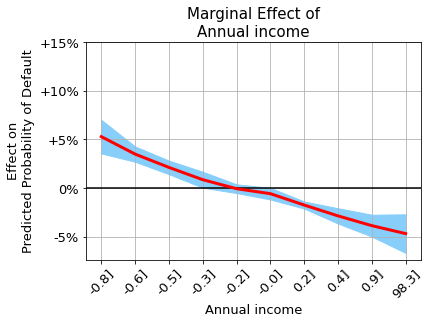

In [0]:
### numeric

var = 'Annual income'

quantiles = pd.qcut(rename_variables(X_train)[var], 10, labels=False)

dp = partial_deltaprob(var, shap_test, shap_df, shap_sum, probas_cat, func_shap2probas=intp, 
                               cutoffs = [rename_variables(X_train)[var].min(),
                                          rename_variables(X_train)[var][quantiles == 0].max(),
                                          rename_variables(X_train)[var][quantiles == 1].max(), 
                                          rename_variables(X_train)[var][quantiles == 2].max(),
                                          rename_variables(X_train)[var][quantiles == 3].max(),
                                          rename_variables(X_train)[var][quantiles == 4].max(),
                                          rename_variables(X_train)[var][quantiles == 5].max(),
                                          rename_variables(X_train)[var][quantiles == 6].max(), 
                                          rename_variables(X_train)[var][quantiles == 7].max(),
                                          rename_variables(X_train)[var][quantiles == 8].max(),
                                          rename_variables(X_train)[var][quantiles == 9].max()])

plt.axhline(0,color='black',zorder=3)
plt.plot(range(len(dp)), dp['mean'], color = 'red', linewidth = 3, label = 'Avg effect',zorder=4)
plt.fill_between(range(len(dp)), dp['mean'] + dp['std'], dp['mean'] - dp['std'],
                 color = 'lightskyblue', label = 'Avg effect +- StDev',zorder=1)
yticks = [-.05,0,.05,.1,.15]
plt.yticks(yticks, [('+' if y > 0 else '') + '{0:.0%}'.format(y) for y in yticks], fontsize=13)
plt.xticks(range(len(dp)), ['{:,.1f}]'.format(x.right) for x in dp.index.to_list()], fontsize=13,rotation=45)

plt.ylabel('Effect on\nPredicted Probability of Default',fontsize=13)
plt.xlabel(var, fontsize=13)
plt.title('Marginal Effect of\n{}'.format(var), fontsize=15)
plt.gca().set_facecolor('white')
plt.grid(zorder=2)

# LR Data

In [0]:
X_train_d_lr = X_train_d.loc[:, ['annual_inc', 'inq_last_6mths', 'dti', 'loan_to_inc', 'revol_util', 'open_acc']]
X_test_d_lr = X_test_d.loc[:, ['annual_inc', 'inq_last_6mths', 'dti', 'loan_to_inc', 'revol_util', 'open_acc']]

Decision boundary is 0.5
Test Result:

accuracy score: 0.6137

Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.63      0.73     16901
           1       0.21      0.54      0.30      3099

    accuracy                           0.61     20000
   macro avg       0.55      0.59      0.52     20000
weighted avg       0.78      0.61      0.67     20000



Predicted 
  NonDef  Def
 [[10586  6315]
 [ 1412  1687]]

#################### The baseline ######################## 
accuracy is:  0.84505 
               precision    recall  f1-score   support

           0       0.85      1.00      0.92     16901
           1       0.00      0.00      0.00      3099

    accuracy                           0.85     20000
   macro avg       0.42      0.50      0.46     20000
weighted avg       0.71      0.85      0.77     20000
 
 [[16901     0]
 [ 3099     0]]
No Skill: ROC AUC=0.500
Model: ROC AUC=0.620


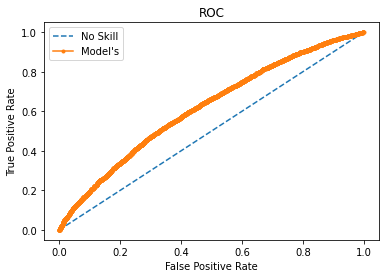

In [0]:
model_lg2 = LogisticRegression(C = 0.0001, random_state=1)
X_train_d_dummied = pd.get_dummies(X_train_d_lr, drop_first = True)

dummied = pd.get_dummies(pd.concat([X_train_d_lr, X_test_d_lr]), drop_first = True)
X_train_d_dummied = dummied.iloc[:X_train_d_lr.shape[0], :]
X_test_d_dummied = dummied.iloc[X_train_d_lr.shape[0]:, :]

model_lg2.fit(X_train_d_dummied, y_pred)
print_score(model_lg2, X_train_d_dummied, y_train, X_test_d_dummied, y_test, border = 0.5)

In [0]:
# extracting coefficients
indices2 = pd.get_dummies(pd.concat([X_train_d_lr, X_test_d_lr]), drop_first = True).columns
lor_coef2 = pd.Series(model_lg2.coef_[0], index = indices2)
lor_coef2 = pd.DataFrame({'exp(β)':lor_coef2.apply(lambda x:np.exp(x))}).round(3).sort_values('exp(β)', ascending = False)
# lor_coef2.style.apply(lambda x: ["background:orangered" if v<1 else "background:lightgreen"
#                                 for v in x], axis = 1)

lor_coef2 = rename_variables(lor_coef2, index = True)

lor_coef2.reset_index().rename(columns = {'index':'Variable'}).style.set_properties(**{'text-align': 'left'})\
.background_gradient('coolwarm', axis = 0).set_precision(3)

In [0]:
lor_coef2.reset_index().rename(columns = {'index':'Parameters'})\
.style.set_properties(**{'text-align': 'left'})\
.background_gradient('coolwarm', axis = 0).set_precision(3)

In [0]:
obs_from = 0
obs_to = 50
variables = [3, 0, 10, 8, 5, 6]

pd.concat([shap_test.iloc[obs_from:obs_to, variables], 
           pd.Series(model_shap.predict(X_test_enc)[obs_from:obs_to, 0])], axis = 1
          ).T.rename({0:'Prediction of default'}).drop(columns = 0).reset_index()

index     1     2     3     4     5     6     7     8     9    10    11    12    13    14    15    16    17    18    19    20    21    22    23    24    25    26    27    28    29    30    31    32    33    34    35    36    37    38    39    40    41    42    43    44    45    46    47    48    49
0                Inquiries in last 6 months  0.43 -0.65  1.52 -0.65 -0.65  1.52 -0.65 -0.65  1.52 -0.65 -0.65 -0.65 -0.65  2.60 -0.65 -0.65  0.43 -0.65  1.52 -0.65  3.69  0.43 -0.65 -0.65  1.52 -0.65 -0.65  0.43 -0.65 -0.65 -0.65 -0.65  1.52 -0.65 -0.65 -0.65 -0.65  0.43 -0.65  0.43  0.43 -0.65 -0.65  0.43  1.52 -0.65  1.52 -0.65  0.43
1                             Annual income -0.72 -0.77 -0.74 -0.43 -0.33 -0.24 -0.62  0.03 -0.92  0.21  0.74 -0.38  0.21 -0.59 -0.24 -0.68  0.88 -0.68  0.30  0.30 -0.33 -0.52  0.03 -0.49 -0.82 -0.63  0.03 -0.95 -0.93 -0.68 -0.18  0.74 -0.15 -0.72  0.02 -0.33 -0.20 -0.42  3.32  0.03 -0.50 -0.36 -0.65 -0.58 -0.15  0.39 -0.68 -0.24 -0.20
2                      Debt to Income ratio  1.22 -0.61  2.16  0.85  1.52 -0.24  1.58 -1.01  0.66 -2.11 -0.15 -0.45 -0.56  1.59 -0.93 -1.33  0.40  2.21  1.59 -0.66  1.03 -1.00 -0.73  1.08  0.41  0.61 -1.19 -1.09  0.83  0.26  0.81 -0.97  1.30 -0.70 -1.06  0.28  1.79 -0.64 -0.00  0.21  0.30  0.58 -0.65 -0.49 -1.84 -1.27 -1.14  0.77 -0.62
3        Loan amount to annual income ratio  1.87  0.82  1.04  0.95  2.33 -0.45 -1.01  0.96  0.88 -0.87 -0.20 -0.24 -0.22 -1.40 -0.16 -0.68 -0.35 -0.15  1.11 -1.13  0.08 -1.23 -1.10  0.33  0.11 -0.33 -1.70  2.89  1.53  0.96  2.32 -1.14 -1.28 -0.16  0.12 -1.22 -1.08  0.59 -1.58  1.68 -0.20  0.56  0.85 -1.02 -0.41 -0.49  0.96 -0.51 -0.50
4                   Credit utilization rate -0.10  0.11  0.15  1.70  0.59 -1.10 -0.68 -0.58 -0.96 -1.84  0.35  0.81  0.17  0.30  0.98 -0.12  0.88  0.07  0.46  0.89 -0.73 -0.97 -1.35  1.01 -2.09  0.55 -1.41 -0.14  0.88  0.37  0.64  1.04 -0.30 -0.90  0.53 -0.66  0.20  0.32  1.25  0.06 -0.54  0.14  1.09 -1.57  1.50 -0.31 -1.21  1.12 -0.59
5  Number of open accounts in credit report -0.66 -0.46 -1.28  0.37  0.57  0.37  2.63 -0.25 -0.46 -0.87  0.16 -0.25  2.01  3.45  0.16 -1.28 -0.05 -0.46 -0.05  0.37  1.81 -1.49  0.16 -0.46 -0.46 -0.66 -0.05 -1.28 -0.87  1.81  0.37 -0.46  1.60  0.16 -1.49  1.19  2.01 -0.05  0.37 -0.46 -0.66 -0.05 -0.87 -0.46 -1.49 -0.25  0.37  1.19 -0.87
6                     Prediction of default  0.83  0.37  0.79  0.85  0.89  0.40  0.28  0.19  0.38  0.28  0.19  0.66  0.73  0.96  0.73  0.75  0.60  0.77  0.79  0.22  0.87  0.61  0.81  0.68  0.86  0.38  0.26  0.87  0.72  0.30  0.28  0.29  0.89  0.83  0.21  0.21  0.87  0.37  0.49  0.59  0.19  0.34  0.78  0.58  0.77  0.46  0.54  0.28  0.25

In [0]:
values = [15, 29]
variables = [0, 3, 0, 10, 8, 5, 6]

pd.concat([shap_test.iloc[values, variables], 
           pd.DataFrame(model_shap.predict(X_test_enc)).iloc[values, 0]], axis = 1
          ).T.rename({0:'Prediction of default'}).reset_index()
### for question
shap_test.iloc[values, variables].T.reset_index().rename(columns = {values[0]:"Borrower A", values[1]:'Borrower B', 'index':'Parameters'}).drop(0)

Parameters  Borrower A  Borrower B
1                Inquiries in last 6 months       -0.65       -0.65
2                             Annual income       -0.24       -0.93
3                      Debt to Income ratio       -0.93        0.83
4        Loan amount to annual income ratio       -0.16        1.53
5                   Credit utilization rate        0.98        0.88
6  Number of open accounts in credit report        0.16       -0.87

In [0]:
both = pd.DataFrame([[99, 99], [0, 0], [90, 55], [20, 30], [10, 10]])
both = pd.DataFrame([[99, 99], [4, 0], [100, 80], [40, 20], [10, 10]])
both = pd.DataFrame([[99, 99], [0, 1], [60, 50], [20, 10], [6, 10]])
both = pd.DataFrame([[99, 99], [3, 0], [125, 125], [20, 25], [10, 20]])
# both = pd.DataFrame([[99, 99], [4, 0], [75, 50], [30, 15], [30, 30]])

both.index = [['a', 'Inquiries in last 6 months', 'Annual income', 'Debt to Income ratio', 'Number of open accounts']]
both.columns = ['Borrower A', 'Borrower B']
both.reset_index().drop(0).rename(columns = {'level_0':'Parameters'})

Parameters  Borrower A  Borrower B
1  Inquiries in last 6 months           3           0
2               Annual income         125         125
3        Debt to Income ratio          20          25
4     Number of open accounts          10          20

# SHAP Data

In [0]:
both = pd.DataFrame([[9, 9, 9, 9, 9], [4, 3, 0.03, 0.025, 0.055], [100, 30, -0.02, 0.02, 0.004], [30, 25, 0.02, 0.013, 0.033], [6, 10, -0.02, 0.012, 0.032]])
both.index = [['X', 'Inquiries in last 6 months', 'Annual income', 'Debt to Income ratio', 'Number of open accounts in credit report']]
both.columns = ['Borrower 1', 'Borrower 2','SHAP 1', 'SHAP 2', 'Importance (SUM of SHAP values)']
both.reset_index().drop(0).rename(columns = {'level_0':'Parameters'})

Parameters  Borrower 1  Borrower 2  SHAP 1  SHAP 2  Importance (SUM of SHAP values)
1                Inquiries in last 6 months           4           3    0.03    0.03                             0.06
2                             Annual income         100          30   -0.02    0.02                             0.00
3                      Debt to Income ratio          30          25    0.02    0.01                             0.03
4  Number of open accounts in credit report           6          10   -0.02    0.01                             0.03

In [0]:
values = [3, 5]
variables = [3, 0, 10, 8, 5, 6]

pd.concat([shap_test.iloc[:70, variables], 
           pd.Series(model_shap.predict(X_test_enc)[:70, 0]),
           y_test[:70]], axis = 1
          ).sort_values('Annual income').T.rename({0:'Prediction of default'}).drop(columns = 0).reset_index().drop(7)

index    55    50    28    29     9    56    62    52    25    60     2    51    63     3    34     1    16    18    47    53    30    57    43    61    26     7    14    44    22    41    59    67    24     4    58    38    12    42    54    66    36    21     5    15     6    48    49    37    31    45    33    69    35    40    27    23    68     8    10    13    65    20    19    46    32    11    64    17    39
0                Inquiries in last 6 months -0.65  0.43  0.43 -0.65  1.52 -0.65  0.43  0.43  1.52 -0.65 -0.65 -0.65 -0.65  1.52 -0.65  0.43 -0.65 -0.65  1.52  1.52 -0.65 -0.65 -0.65 -0.65 -0.65 -0.65  2.60  0.43  0.43  0.43 -0.65 -0.65 -0.65 -0.65 -0.65  0.43 -0.65 -0.65 -0.65 -0.65 -0.65  3.69 -0.65 -0.65  1.52 -0.65  0.43 -0.65 -0.65  1.52  1.52 -0.65 -0.65  0.43 -0.65 -0.65  1.52 -0.65 -0.65 -0.65 -0.65 -0.65  1.52 -0.65 -0.65 -0.65 -0.65  0.43 -0.65
1                             Annual income -1.16 -0.99 -0.95 -0.93 -0.92 -0.91 -0.86 -0.84 -0.82 -0.78 -0.77 -0.76 -0.75 -0.74 -0.72 -0.72 -0.68 -0.68 -0.68 -0.68 -0.68 -0.68 -0.65 -0.65 -0.63 -0.62 -0.59 -0.58 -0.52 -0.50 -0.50 -0.50 -0.49 -0.43 -0.42 -0.42 -0.38 -0.36 -0.33 -0.33 -0.33 -0.33 -0.33 -0.24 -0.24 -0.24 -0.20 -0.20 -0.18 -0.15 -0.15 -0.04  0.02  0.03  0.03  0.03  0.03  0.03  0.21  0.21  0.24  0.30  0.30  0.39  0.74  0.74  0.74  0.88  3.32
2                      Debt to Income ratio -1.12  1.01 -1.09  0.83  0.66  1.30  1.33  1.27  0.41  2.12 -0.61  0.13 -1.17  2.16 -0.70  1.22 -1.33  2.21 -1.14  0.82  0.26  0.21 -0.65  0.39  0.61  1.58  1.59 -0.49 -1.00  0.30 -1.59  0.79  1.08  0.85 -0.67 -0.64 -0.45  0.58 -0.30  2.63  0.28  1.03  1.52 -0.93 -0.24  0.77 -0.62  1.79  0.81 -1.84  1.30  0.03 -1.06  0.21 -1.19 -0.73 -0.06 -1.01 -2.11 -0.56 -0.53 -0.66  1.59 -1.27 -0.97 -0.15 -1.63  0.40 -0.00
3        Loan amount to annual income ratio  0.84 -1.20  2.89  1.53  0.88 -1.51  1.44 -0.08  0.11  0.86  0.82  0.68 -1.12  1.04 -0.16  1.87 -0.68 -0.15  0.96 -0.73  0.96  1.44  0.85 -0.22 -0.33 -1.01 -1.40 -1.02 -1.23 -0.20 -0.01 -0.98  0.33  0.95  0.69  0.59 -0.24  0.56  0.48  1.28 -1.22  0.08  2.33 -0.16 -0.45 -0.51 -0.50 -1.08  2.32 -0.41 -1.28  0.35  0.12  1.68 -1.70 -1.10  1.68  0.96 -0.87 -0.22  0.27 -1.13  1.11 -0.49 -1.14 -0.20 -0.73 -0.35 -1.58
4                   Credit utilization rate  1.03 -0.16 -0.14  0.88 -0.96  1.09 -0.94 -0.06 -2.09  0.18  0.11  0.34 -1.12  0.15 -0.90 -0.10 -0.12  0.07 -1.21 -1.15  0.37 -0.45  1.09  0.19  0.55 -0.68  0.30 -1.57 -0.97 -0.54  1.06 -0.04  1.01  1.70 -1.85  0.32  0.81  0.14  1.20 -0.02 -0.66 -0.73  0.59  0.98 -1.10  1.12 -0.59  0.20  0.64  1.50 -0.30 -0.02  0.53  0.06 -1.41 -1.35  0.05 -0.58 -1.84  0.17 -0.47  0.89  0.46 -0.31  1.04  0.35 -1.03  0.88  1.25
5  Number of open accounts in credit report  0.57 -1.69 -1.28 -0.87 -0.46 -0.05  0.37 -1.08 -0.46 -0.25 -0.46 -1.08  0.16 -1.28  0.16 -0.66 -1.28 -0.46  0.37 -0.46  1.81 -0.25 -0.87 -0.87 -0.66  2.63  3.45 -0.46 -1.49 -0.66 -1.28  0.98 -0.46  0.37 -0.46 -0.05 -0.25 -0.05 -0.87  2.22  1.19  1.81  0.57  0.16  0.37  1.19 -0.87  2.01  0.37 -1.49  1.60  0.78 -1.49 -0.46 -0.05  0.16  1.39 -0.25 -0.87  2.01 -0.46  0.37 -0.05 -0.25 -0.46  0.16 -0.25 -0.05  0.37
6                     Prediction of default  0.90  0.80  0.87  0.72  0.38  0.85  0.90  0.81  0.86  0.67  0.37  0.22  0.24  0.79  0.83  0.83  0.75  0.77  0.54  0.78  0.30  0.52  0.78  0.19  0.38  0.28  0.96  0.58  0.61  0.19  0.74  0.48  0.68  0.85  0.22  0.37  0.66  0.34  0.33  0.46  0.21  0.87  0.89  0.73  0.40  0.28  0.25  0.87  0.28  0.77  0.89  0.23  0.21  0.59  0.26  0.81  0.93  0.19  0.28  0.73  0.20  0.22  0.79  0.46  0.29  0.19  0.17  0.60  0.49

In [0]:
values = [5, 50]
variables = [1, 3, 0, 10, 8, 5, 6]


pd.concat([shap_test.iloc[values, variables], 
           pd.DataFrame(model_shap.predict(X_test_enc)).iloc[values, 0]], axis = 1
          ).T.rename({0:'Prediction of default'}).reset_index().drop(0)
# shap_test.iloc[values, variables].T.reset_index().rename(columns = {values[0]:"Borrower A", values[1]:'Borrower B', 'index':'Parameters'}).drop(0)

index     5    50
1                Inquiries in last 6 months -0.65  0.43
2                             Annual income -0.33 -0.99
3                      Debt to Income ratio  1.52  1.01
4        Loan amount to annual income ratio  2.33 -1.20
5                   Credit utilization rate  0.59 -0.16
6  Number of open accounts in credit report  0.57 -1.69
7                     Prediction of default  0.89  0.80

In [0]:
a = pd.concat([shap_test.iloc[values, variables].T, 
           (shap_df.iloc[values, variables].T*100).rename(columns = {values[0]:"SHAP A", values[1]:'SHAP B'})
           ], 
          axis = 1)
a
# pd.concat([a, 
#            pd.DataFrame(modelmodel_shap_mine.predict(X_test_enc)).iloc[values, 0]], axis = 0
#           ).rename({0:'Prediction of default'}).reset_index()

5    50  SHAP A  SHAP B
Time from first credit line in credit report -0.93 -0.91    2.27    0.72
Inquiries in last 6 months                   -0.65  0.43   -1.55    1.19
Annual income                                -0.33 -0.99    0.73    5.59
Debt to Income ratio                          1.52  1.01    2.38    4.30
Loan amount to annual income ratio            2.33 -1.20    7.24   -1.92
Credit utilization rate                       0.59 -0.16    0.66   -0.61
Number of open accounts in credit report      0.57 -1.69    0.77   -3.97

In [0]:
shap_df.iloc[values, variables].T*100

5     50
Time from first credit line in credit report  2.27  0.72
Inquiries in last 6 months                   -1.55  1.19
Annual income                                 0.73  5.59
Debt to Income ratio                          2.38  4.30
Loan amount to annual income ratio            7.24 -1.92
Credit utilization rate                       0.66 -0.61
Number of open accounts in credit report      0.77 -3.97

In [0]:
observation_index = 59
observation_index = values[0]
# print(shap_test.iloc[observation_index, variables].T)

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_df.iloc[observation_index, :].values, 
                shap_test.loc[observation_index, :])   # if shap_test is a DataFrame

In [0]:
observation_index = values[1]

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_df.iloc[observation_index, :].values, 
                shap_test.loc[observation_index, :])   # if shap_test is a DataFrame


# SHAP 2 Prob

In [0]:
both = pd.DataFrame([[3, 1, 0, 4.6, 0, -2.81], [120, 50, 90, -7, 5.34, -4.55], [30, 20, 10, 9, 6, -2.2], [20, 12, 5, 3.5, 2.61, -3.94], 
                     [0.56, 0.63, 0.14, '-', '-', '-'], ['-', '-', '-', 10.1, 13.95, -13.5]])
both.index = [['Inquiries in last 6 months', 'Annual income', 'Debt to Income ratio', 'Number of open accounts in credit reports', 'Prediction of default','SUM of SHAP values']]
both.columns = ['Borrower 1', 'Borrower 2', 'Borrower 3', 'SHAP 1', 'SHAP 2', 'SHAP 3']
both

Borrower 1 Borrower 2 Borrower 3 SHAP 1 SHAP 2 SHAP 3
Inquiries in last 6 months                         3          1          0   4.60      0  -2.81
Annual income                                    120         50         90     -7   5.34  -4.55
Debt to Income ratio                              30         20         10      9      6  -2.20
Number of open accounts in credit reports         20         12          5   3.50   2.61  -3.94
Prediction of default                           0.56       0.63       0.14      -      -      -
SUM of SHAP values                                 -          -          -  10.10  13.95 -13.50

In [0]:
# pd.concat([shap_test.iloc[:70, variables].drop(columns = 'Time from first credit line in credit report'), 
#            pd.Series(modemodel_shapl_mine.predict(X_test_enc)[:70, 0]),
#            y_test[:70]], axis = 1
#           ).sort_values('Annual income').T.rename({0:'Prediction of default'}).drop(columns = 0).reset_index().drop(7)

In [0]:
shap_test.iloc[:70, variables].T

0     1     2     3     4     5     6     7     8     9    10    11    12    13    14    15    16    17    18    19    20    21    22    23    24    25    26    27    28    29    30    31    32    33    34    35    36    37    38    39    40    41    42    43    44    45    46    47    48    49    50    51    52    53    54    55    56    57    58    59    60    61    62    63    64    65    66    67    68    69
Time from first credit line in credit report -1.15 -1.23 -0.47 -0.00  2.77 -0.93  0.04  0.72  0.19 -1.12 -1.53 -0.56 -0.99 -0.24 -1.11 -0.90 -0.42 -0.56 -1.03 -0.76  0.28 -0.24 -1.01 -1.05 -1.01 -1.53  0.53 -0.33  0.27  0.05 -0.40  0.17 -0.66  2.12 -0.62  2.24 -0.94  1.44 -0.58  2.62 -0.01  0.73 -0.89 -0.67 -0.69 -1.22 -0.19  0.47  1.64 -0.87 -0.91  0.29 -1.04 -0.30  0.37 -1.59  2.15 -1.41  0.60  0.04 -0.87 -0.37  0.87  0.83  0.59 -0.76  0.25 -0.19  2.29  1.86
Inquiries in last 6 months                   -0.65  0.43 -0.65  1.52 -0.65 -0.65  1.52 -0.65 -0.65  1.52 -0.65 -0.65 -0.65 -0.65  2.60 -0.65 -0.65  0.43 -0.65  1.52 -0.65  3.69  0.43 -0.65 -0.65  1.52 -0.65 -0.65  0.43 -0.65 -0.65 -0.65 -0.65  1.52 -0.65 -0.65 -0.65 -0.65  0.43 -0.65  0.43  0.43 -0.65 -0.65  0.43  1.52 -0.65  1.52 -0.65  0.43  0.43 -0.65  0.43  1.52 -0.65 -0.65 -0.65 -0.65 -0.65 -0.65 -0.65 -0.65  0.43 -0.65 -0.65 -0.65 -0.65 -0.65  1.52 -0.65
Annual income                                -0.95 -0.72 -0.77 -0.74 -0.43 -0.33 -0.24 -0.62  0.03 -0.92  0.21  0.74 -0.38  0.21 -0.59 -0.24 -0.68  0.88 -0.68  0.30  0.30 -0.33 -0.52  0.03 -0.49 -0.82 -0.63  0.03 -0.95 -0.93 -0.68 -0.18  0.74 -0.15 -0.72  0.02 -0.33 -0.20 -0.42  3.32  0.03 -0.50 -0.36 -0.65 -0.58 -0.15  0.39 -0.68 -0.24 -0.20 -0.99 -0.76 -0.84 -0.68 -0.33 -1.16 -0.91 -0.68 -0.42 -0.50 -0.78 -0.65 -0.86 -0.75  0.74  0.24 -0.33 -0.50  0.03 -0.04
Debt to Income ratio                         -0.90  1.22 -0.61  2.16  0.85  1.52 -0.24  1.58 -1.01  0.66 -2.11 -0.15 -0.45 -0.56  1.59 -0.93 -1.33  0.40  2.21  1.59 -0.66  1.03 -1.00 -0.73  1.08  0.41  0.61 -1.19 -1.09  0.83  0.26  0.81 -0.97  1.30 -0.70 -1.06  0.28  1.79 -0.64 -0.00  0.21  0.30  0.58 -0.65 -0.49 -1.84 -1.27 -1.14  0.77 -0.62  1.01  0.13  1.27  0.82 -0.30 -1.12  1.30  0.21 -0.67 -1.59  2.12  0.39  1.33 -1.17 -1.63 -0.53  2.63  0.79 -0.06  0.03
Loan amount to annual income ratio           -0.39  1.87  0.82  1.04  0.95  2.33 -0.45 -1.01  0.96  0.88 -0.87 -0.20 -0.24 -0.22 -1.40 -0.16 -0.68 -0.35 -0.15  1.11 -1.13  0.08 -1.23 -1.10  0.33  0.11 -0.33 -1.70  2.89  1.53  0.96  2.32 -1.14 -1.28 -0.16  0.12 -1.22 -1.08  0.59 -1.58  1.68 -0.20  0.56  0.85 -1.02 -0.41 -0.49  0.96 -0.51 -0.50 -1.20  0.68 -0.08 -0.73  0.48  0.84 -1.51  1.44  0.69 -0.01  0.86 -0.22  1.44 -1.12 -0.73  0.27  1.28 -0.98  1.68  0.35
Credit utilization rate                      -0.74 -0.10  0.11  0.15  1.70  0.59 -1.10 -0.68 -0.58 -0.96 -1.84  0.35  0.81  0.17  0.30  0.98 -0.12  0.88  0.07  0.46  0.89 -0.73 -0.97 -1.35  1.01 -2.09  0.55 -1.41 -0.14  0.88  0.37  0.64  1.04 -0.30 -0.90  0.53 -0.66  0.20  0.32  1.25  0.06 -0.54  0.14  1.09 -1.57  1.50 -0.31 -1.21  1.12 -0.59 -0.16  0.34 -0.06 -1.15  1.20  1.03  1.09 -0.45 -1.85  1.06  0.18  0.19 -0.94 -1.12 -1.03 -0.47 -0.02 -0.04  0.05 -0.02
Number of open accounts in credit report     -0.25 -0.66 -0.46 -1.28  0.37  0.57  0.37  2.63 -0.25 -0.46 -0.87  0.16 -0.25  2.01  3.45  0.16 -1.28 -0.05 -0.46 -0.05  0.37  1.81 -1.49  0.16 -0.46 -0.46 -0.66 -0.05 -1.28 -0.87  1.81  0.37 -0.46  1.60  0.16 -1.49  1.19  2.01 -0.05  0.37 -0.46 -0.66 -0.05 -0.87 -0.46 -1.49 -0.25  0.37  1.19 -0.87 -1.69 -1.08 -1.08 -0.46 -0.87  0.57 -0.05 -0.25 -0.46 -1.28 -0.25 -0.87  0.37  0.16 -0.25 -0.46  2.22  0.98  1.39  0.78

In [0]:
values = [59, 31]
variables = [3, 0, 10, 8, 5, 6]


pd.concat([shap_test.iloc[values, variables], 
           pd.DataFrame(model_shap.predict(X_test_enc)).iloc[values, 0]], axis = 1
          ).T.rename({0:'Prediction of default'}).reset_index()
shap_test.iloc[values, variables].T.reset_index().rename(columns = {values[0]:"Borrower A", values[1]:'Borrower B', 'index':'Parameters of the model'})

Parameters of the model  Borrower A  Borrower B
0                Inquiries in last 6 months       -0.65       -0.65
1                             Annual income       -0.50       -0.18
2                      Debt to Income ratio       -1.59        0.81
3        Loan amount to annual income ratio       -0.01        2.32
4                   Credit utilization rate        1.06        0.64
5  Number of open accounts in credit report       -1.28        0.37

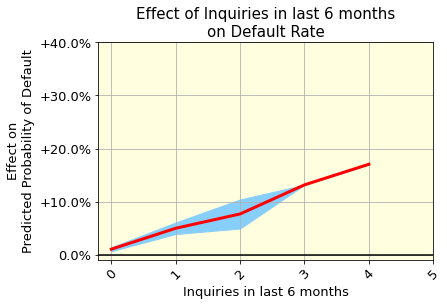

In [0]:
### numeric
var = 'Inquiries in last 6 months'

dp = partial_deltaprob(var, shap_test, shap_df, shap_sum, probas_cat, func_shap2probas=intp, 
                               cutoffs = [0, 1, 2, 3, 4, 5, 6])

plt.axhline(0,color='black',zorder=3)
plt.plot(range(len(dp)), dp['mean'], color = 'red', linewidth = 3, label = 'Avg effect',zorder=4)
plt.fill_between(range(len(dp)), dp['mean'] + dp['std'], dp['mean'] - dp['std'],
                 color = 'lightskyblue', label = 'Avg effect +- StDev',zorder=1)
yticks = [0, 0.1, .2,.3,.4]
plt.yticks(yticks, [('+' if y > 0 else '') + '{0:.1%}'.format(y) for y in yticks], fontsize=13)
plt.xticks(range(len(dp)), ['{:,.0f}'.format(x.left) for x in dp.index.to_list()], fontsize=13,rotation=45)

plt.ylabel('Effect on\nPredicted Probability of Default',fontsize=13)
plt.xlabel(var, fontsize=13)
plt.title('Effect of {}\non Default Rate'.format(var), fontsize=15)
plt.gca().set_facecolor('lightyellow')
plt.grid(zorder=2)

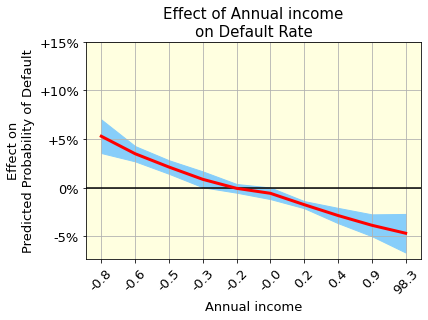

In [0]:
### numeric

var = 'Annual income'

quantiles = pd.qcut(rename_variables(X_train)[var], 10, labels=False)

dp = partial_deltaprob(var, shap_test, shap_df, shap_sum, probas_cat, func_shap2probas=intp, 
                               cutoffs = [rename_variables(X_train)[var].min(),
                                          rename_variables(X_train)[var][quantiles == 0].max(),
                                          rename_variables(X_train)[var][quantiles == 1].max(), 
                                          rename_variables(X_train)[var][quantiles == 2].max(),
                                          rename_variables(X_train)[var][quantiles == 3].max(),
                                          rename_variables(X_train)[var][quantiles == 4].max(),
                                          rename_variables(X_train)[var][quantiles == 5].max(),
                                          rename_variables(X_train)[var][quantiles == 6].max(), 
                                          rename_variables(X_train)[var][quantiles == 7].max(),
                                          rename_variables(X_train)[var][quantiles == 8].max(),
                                          rename_variables(X_train)[var][quantiles == 9].max()])

plt.axhline(0,color='black',zorder=3)
plt.plot(range(len(dp)), dp['mean'], color = 'red', linewidth = 3, label = 'Avg effect',zorder=4)
plt.fill_between(range(len(dp)), dp['mean'] + dp['std'], dp['mean'] - dp['std'],
                 color = 'lightskyblue', label = 'Avg effect +- StDev',zorder=1)
yticks = [-.05,0,.05,.1,.15]
plt.yticks(yticks, [('+' if y > 0 else '') + '{0:.0%}'.format(y) for y in yticks], fontsize=13)
plt.xticks(range(len(dp)), ['{:,.1f}'.format(x.right) for x in dp.index.to_list()], fontsize=13,rotation=45)

plt.ylabel('Effect on\nPredicted Probability of Default',fontsize=13)
plt.xlabel(var, fontsize=13)
plt.title('Effect of {}\non Default Rate'.format(var), fontsize=15)
plt.gca().set_facecolor('lightyellow')
plt.grid(zorder=2)

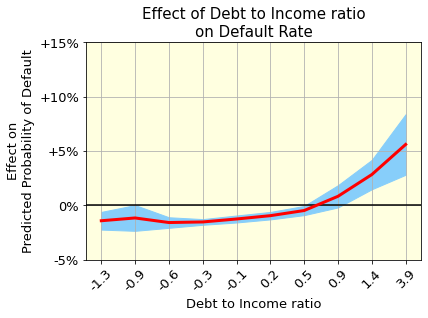

In [0]:
### numeric
var = 'Debt to Income ratio'

quantiles = pd.qcut(rename_variables(X_train)[var], 10, labels=False)
dp = partial_deltaprob(var, shap_test, shap_df, shap_sum, probas_cat, func_shap2probas=intp, 
                               cutoffs = [rename_variables(X_train)[var].min(),
                                          rename_variables(X_train)[var][quantiles == 0].max(),
                                          rename_variables(X_train)[var][quantiles == 1].max(), 
                                          rename_variables(X_train)[var][quantiles == 2].max(),
                                          rename_variables(X_train)[var][quantiles == 3].max(),
                                          rename_variables(X_train)[var][quantiles == 4].max(),
                                          rename_variables(X_train)[var][quantiles == 5].max(),
                                          rename_variables(X_train)[var][quantiles == 6].max(), 
                                          rename_variables(X_train)[var][quantiles == 7].max(),
                                          rename_variables(X_train)[var][quantiles == 8].max(),
                                          rename_variables(X_train)[var][quantiles == 9].max()])

plt.axhline(0,color='black',zorder=3)
plt.plot(range(len(dp)), dp['mean'], color = 'red', linewidth = 3, label = 'Avg effect',zorder=4)
plt.fill_between(range(len(dp)), dp['mean'] + dp['std'], dp['mean'] - dp['std'],
                 color = 'lightskyblue', label = 'Avg effect +- StDev',zorder=1)
yticks = [-.05,0,.05,.1,.15]
plt.yticks(yticks, [('+' if y > 0 else '') + '{0:.0%}'.format(y) for y in yticks], fontsize=13)
plt.xticks(range(len(dp)), ['{:,.1f}'.format(x.right) for x in dp.index.to_list()], fontsize=13,rotation=45)

plt.ylabel('Effect on\nPredicted Probability of Default',fontsize=13)
plt.xlabel(var, fontsize=13)
plt.title('Effect of {}\non Default Rate'.format(var), fontsize=15)
plt.gca().set_facecolor('lightyellow')
plt.grid(zorder=2)

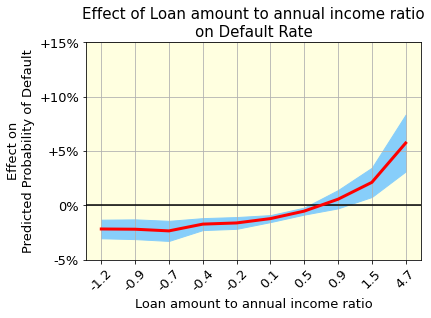

In [0]:
### numeric
var = 'Loan amount to annual income ratio'

quantiles = pd.qcut(rename_variables(X_train)[var], 10, labels=False)
dp = partial_deltaprob(var, shap_test, shap_df, shap_sum, probas_cat, func_shap2probas=intp, 
                               cutoffs = [rename_variables(X_train)[var].min(),
                                          rename_variables(X_train)[var][quantiles == 0].max(),
                                          rename_variables(X_train)[var][quantiles == 1].max(), 
                                          rename_variables(X_train)[var][quantiles == 2].max(),
                                          rename_variables(X_train)[var][quantiles == 3].max(),
                                          rename_variables(X_train)[var][quantiles == 4].max(),
                                          rename_variables(X_train)[var][quantiles == 5].max(),
                                          rename_variables(X_train)[var][quantiles == 6].max(), 
                                          rename_variables(X_train)[var][quantiles == 7].max(),
                                          rename_variables(X_train)[var][quantiles == 8].max(),
                                          rename_variables(X_train)[var][quantiles == 9].max()])

plt.axhline(0,color='black',zorder=3)
plt.plot(range(len(dp)), dp['mean'], color = 'red', linewidth = 3, label = 'Avg effect',zorder=4)
plt.fill_between(range(len(dp)), dp['mean'] + dp['std'], dp['mean'] - dp['std'],
                 color = 'lightskyblue', label = 'Avg effect +- StDev',zorder=1)
yticks = [-.05,0,.05,.1,.15]
plt.yticks(yticks, [('+' if y > 0 else '') + '{0:.0%}'.format(y) for y in yticks], fontsize=13)
plt.xticks(range(len(dp)), ['{:,.1f}'.format(x.right) for x in dp.index.to_list()], fontsize=13,rotation=45)

plt.ylabel('Effect on\nPredicted Probability of Default',fontsize=13)
plt.xlabel(var, fontsize=13)
plt.title('Effect of {}\non Default Rate'.format(var), fontsize=15)
plt.gca().set_facecolor('lightyellow')
plt.grid(zorder=2)

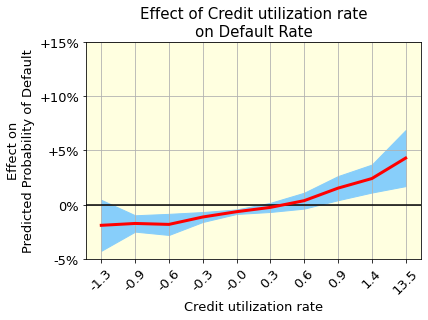

In [0]:
### numeric
var = 'Credit utilization rate'

quantiles = pd.qcut(rename_variables(X_train)[var], 10, labels=False)
dp = partial_deltaprob(var, shap_test, shap_df, shap_sum, probas_cat, func_shap2probas=intp, 
                               cutoffs = [rename_variables(X_train)[var].min(),
                                          rename_variables(X_train)[var][quantiles == 0].max(),
                                          rename_variables(X_train)[var][quantiles == 1].max(), 
                                          rename_variables(X_train)[var][quantiles == 2].max(),
                                          rename_variables(X_train)[var][quantiles == 3].max(),
                                          rename_variables(X_train)[var][quantiles == 4].max(),
                                          rename_variables(X_train)[var][quantiles == 5].max(),
                                          rename_variables(X_train)[var][quantiles == 6].max(), 
                                          rename_variables(X_train)[var][quantiles == 7].max(),
                                          rename_variables(X_train)[var][quantiles == 8].max(),
                                          rename_variables(X_train)[var][quantiles == 9].max()])

plt.axhline(0,color='black',zorder=3)
plt.plot(range(len(dp)), dp['mean'], color = 'red', linewidth = 3, label = 'Avg effect',zorder=4)
plt.fill_between(range(len(dp)), dp['mean'] + dp['std'], dp['mean'] - dp['std'],
                 color = 'lightskyblue', label = 'Avg effect +- StDev',zorder=1)
yticks = [-.05,0,.05,.1,.15]
plt.yticks(yticks, [('+' if y > 0 else '') + '{0:.0%}'.format(y) for y in yticks], fontsize=13)
plt.xticks(range(len(dp)), ['{:,.1f}'.format(x.right) for x in dp.index.to_list()], fontsize=13,rotation=45)

plt.ylabel('Effect on\nPredicted Probability of Default',fontsize=13)
plt.xlabel(var, fontsize=13)
plt.title('Effect of {}\non Default Rate'.format(var), fontsize=15)
plt.gca().set_facecolor('lightyellow')
plt.grid(zorder=2)

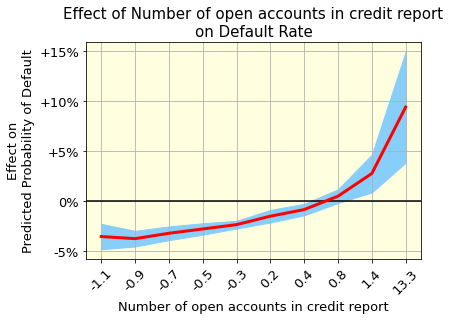

In [0]:
### numeric
var = 'Number of open accounts in credit report'

quantiles = pd.qcut(rename_variables(X_train)[var], 10, labels=False)
dp = partial_deltaprob(var, shap_test, shap_df, shap_sum, probas_cat, func_shap2probas=intp, 
                               cutoffs = [rename_variables(X_train)[var].min(),
                                          rename_variables(X_train)[var][quantiles == 0].max(),
                                          rename_variables(X_train)[var][quantiles == 1].max(), 
                                          rename_variables(X_train)[var][quantiles == 2].max(),
                                          rename_variables(X_train)[var][quantiles == 3].max(),
                                          rename_variables(X_train)[var][quantiles == 4].max(),
                                          rename_variables(X_train)[var][quantiles == 5].max(),
                                          rename_variables(X_train)[var][quantiles == 6].max(), 
                                          rename_variables(X_train)[var][quantiles == 7].max(),
                                          rename_variables(X_train)[var][quantiles == 8].max(),
                                          rename_variables(X_train)[var][quantiles == 9].max()])

plt.axhline(0,color='black',zorder=3)
plt.plot(range(len(dp)), dp['mean'], color = 'red', linewidth = 3, label = 'Avg effect',zorder=4)
plt.fill_between(range(len(dp)), dp['mean'] + dp['std'], dp['mean'] - dp['std'],
                 color = 'lightskyblue', label = 'Avg effect +- StDev',zorder=1)
yticks = [-.05,0,.05,.1,.15]
plt.yticks(yticks, [('+' if y > 0 else '') + '{0:.0%}'.format(y) for y in yticks], fontsize=13)
plt.xticks(range(len(dp)), ['{:,.1f}'.format(x.right) for x in dp.index.to_list()], fontsize=13,rotation=45)

plt.ylabel('Effect on\nPredicted Probability of Default',fontsize=13)
plt.xlabel(var, fontsize=13)
plt.title('Effect of {}\non Default Rate'.format(var), fontsize=15)
plt.gca().set_facecolor('lightyellow')
plt.grid(zorder=2)

# **Junk**

In [0]:
pd.concat([shap_test.iloc[:4, [0, 5, 10, 11]], 
           pd.Series(model_shap.predict(X_test_enc)[:4, 0])], axis = 1
          ).T.rename({0:'Prediction of default'}).drop(columns = 0)

1     2     3
Annual income           -0.72 -0.77 -0.74
Credit utilization rate -0.10  0.11  0.15
Debt to Income ratio     1.22 -0.61  2.16
Sub grade               19.00  7.00 20.00
Prediction of default    0.83  0.37  0.79

In [0]:
pd.concat([shap_test.iloc[:4, [0, 5, 10, 11]], 
           pd.Series(model_shap.predict(X_test_enc)[:4, 0])], axis = 1
          ).T.rename({0:'Prediction of default'}).drop(columns = 0)

1     2     3
Annual income           -0.72 -0.77 -0.74
Credit utilization rate -0.10  0.11  0.15
Debt to Income ratio     1.22 -0.61  2.16
Sub grade               19.00  7.00 20.00
Prediction of default    0.83  0.37  0.79

In [0]:
a = pd.concat([(shap_df*100).iloc[:4, [0, 5, 10, 11]], 
           pd.Series(model_shap.predict(X_test_enc)[:4, 0])], axis = 1
          ).T.rename({0:'Prediction of default'}).drop(columns = 0)

pd.DataFrame([[]])

Empty DataFrame
Columns: []
Index: [0]